

# Dependencies



In [43]:

#!pip install h2o 
#!pip install joblib -U
#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from joblib import dump, load
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN

# some colors for textual representation
class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [44]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [45]:
class Dataset():
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
  
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  def load(self):
    self.csv_data=pd.read_csv(self.path)
    self.csv_data[self.label]=self.csv_data[self.label].apply(self.new_classes)
    return self.csv_data
  
  def set_data(self,data):
    self.csv_data=data

  def get_label(self):
    return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)

  def get_features(self):
    return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  def class_balance(self,data):
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  def get_corr_analysis(self):
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[label],method="spearman").reset_index()
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    return self.class_corr
    
  
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  def save(self,path):
      self.csv_data.to_csv(path,index=False)


class Modifier(Dataset):

  def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
    super().__init__(new_path,label,use_case,class_values,to_drop)
    self.newdata=pd.DataFrame()
    self.improvement=0
  
  def update_csv(self):
    self.csv_data=self.newdata
    self.newdata=pd.DataFrame()

  def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
    self.newdata=pd.concat([X,y],axis=1)


  def reduce(self,cluster_model,custom_ratio=None):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    reduction=cluster_model.reduction.array
    cluster_model.predict(self)
    reduction_data=cluster_model.result_new[cluster_model.result_new['predict'].isin(reduction)]
    no_reduction_data=cluster_model.result_new[~cluster_model.result_new['predict'].isin(reduction)]
    #print(reduction_data,no_reduction_data)

    for red_can in reduction:
      data_for_sample=reduction_data[reduction_data["predict"]==red_can]
      reduction_ratio=self.get_ratio(data_for_sample.shape[0],cluster_model.result_new.shape[0],cluster_model.size,)
      
      if reduction_ratio < 1:
        if custom_ratio is not None:
          if custom_ratio == 1/cluster_model.size:
            reduction_ratio=custom_ratio/(data_for_sample.shape[0]/cluster_model.result_new.shape[0])
          else: 
            reduction_ratio=custom_ratio
        sampled=data_for_sample.sample(frac=reduction_ratio,random_state=42)
        print("New ratio",sampled.shape[0]/cluster_model.result_new.shape[0]*100)
        no_reduction_data=pd.concat([no_reduction_data,sampled])
      else:
        no_reduction_data=pd.concat([no_reduction_data,data_for_sample])
      print("Reduction coef",reduction_ratio)
    index_reduction=no_reduction_data
    self.newdata=pd.concat([self.newdata,index_reduction.join(cluster_model.data.X).drop(columns=["predict"]).join(cluster_model.data.y)])
    return cluster_model.result_new.shape[0]-index_reduction.shape[0]
 
  def augument(self,cluster_model,custom_ratio=None):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    new_data=cluster_model.result_new[cluster_model.result_new["predict"].isin(cluster_model.augument)]
    new_data_sampled=pd.DataFrame()
    for aug_can in cluster_model.augument.array:
      data_to_sample=new_data[new_data["predict"]==aug_can]
      ratio=self.get_ratio(data_to_sample.shape[0],cluster_model.result_new.shape[0],cluster_model.size)
      if custom_ratio is not None:
          if custom_ratio == 1/cluster_model.size:
            ratio=custom_ratio/(data_to_sample.shape[0]/cluster_model.result_new.shape[0])
          elif custom_ratio == 'all': 
            ratio=1
          else: ratio=custom_ratio
      #aug_size=int(data_to_sample.shape[0]*ratio)
      print("new ratio aug:",ratio)
      if ratio <= 1:
        data_to_sample=data_to_sample.sample(frac=ratio,random_state=42)
      else:
        data_to_sample=data_to_sample.sample(frac=1,random_state=42)
      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("new data sampled",cluster_model.class_number)
    print(new_data_sampled.shape)
    self.newdata=pd.concat([self.newdata,new_data_sampled])

  def augument_coeff(self,cluster_model,reduced_amount,custom_ratio=None):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    self.get_data_amount(cluster_model)
    print("POTENTIAL AMOUNT",self.potential_amount)
    print("REDUCED AMOUNT",reduced_amount)
    aug_weight=min(reduced_amount/self.potential_amount,1)
    new_data_sampled=pd.DataFrame()
    for aug_can,coeff in cluster_model.augument.items():
      data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
      data_to_sample=data_to_sample.sample(frac=coeff*aug_weight,random_state=42)

      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])
    new_data_sampled.value_counts().plot(kind='bar')
    #print(new_data_sampled)
    plt.show()
    #plt.clf()
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("new data sampled",cluster_model.class_number)
    print(new_data_sampled.shape)
    self.newdata=pd.concat([self.newdata,new_data_sampled])
  
  def get_ratio(self,cluster_data_size,whole_data_size,clusters_amount):
    cluster_ratio=cluster_data_size/whole_data_size*100
    print("K ratio",100/clusters_amount)
    print("Original ratio",cluster_ratio)
    cluster_avg=0.5*(cluster_ratio+100/clusters_amount)
    return cluster_avg/cluster_ratio
  
  def get_data_amount(self,model):
    self.potential_amount=0
    clusters,counts=np.unique(model.result_new,return_counts=True)
    for cluster,amount in zip(clusters,counts):
      self.potential_amount+=model.augument[cluster]*amount
    self.potential_amount=int(self.potential_amount)
  
  def compare_models(self,old,new,test_data):
    
    X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
    y_train=self.newdata[self.label].reset_index(drop=True)
    new.fit(X_train,y_train)

    cnt_old=self.class_balance(self.get_all_label())
    self.cnt_new=self.class_balance(y_train)
    print("Old class balance",cnt_old)
    print("New class balance",self.cnt_new)
    print("Reduction ratio",100-self.cnt_new['all']/cnt_old['all']*100)
    X=test_data.get_all_features()
    y=test_data.get_all_label()

    pred_old = old.predict(X)
    print(classification_report(y,pred_old,digits=4))
    #total_acc=metrics.accuracy_score(y,pred_old)
    metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred_old) ).plot()
    plt.show()

    pred_new = new.predict(X)
    print(classification_report(y,pred_new,digits=4))
    #total_acc=metrics.accuracy_score(y,pred_new)
    metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred_new) ).plot()
    plt.show()
  

    # metrics.f1_score(y,pred_new,average="weighted")
    f1_old=metrics.f1_score(y,pred_old,average="weighted")
    f1_new=metrics.f1_score(y,pred_new,average="weighted")
    #print(f1_old,f1_new)
    space_to_improve=1-f1_old
    self.improvement=(f1_new-f1_old)/space_to_improve*100
    print("Improvement",self.improvement)

    return classification_report(y,pred_new,digits=4,output_dict=True)
  
  def apply_imbalanced_lib(self,sampler,prep=False):
    X_old=self.get_all_features()
    y_old=self.get_all_label()
    if prep:
        pipe=make_pipeline(StandardScaler(),VarianceThreshold())
        X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
        X_res=pipe.inverse_transform(X_res)
        X_res=pd.DataFrame(X_res, columns = X_old.columns)
    else:
        X_res, y_res = sampler.fit_resample(X_old, y_old)
        
    self.set_newdata(X_res, y_res)
  
  def prepare_model_result(self,report,method,dataset,metric='default'):
    #Methods OA Precision Recall F measure
    return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

  def save_fig(self,y,pred,text):
    fig=metrics.ConfusionMatrixDisplay.from_predictions( y,pred).figure_
    fig.set_figwidth(8)
    fig.set_figheight(8)  
    fig.savefig(f"/content/drive/My Drive/Cluster/{self.use_case}/CM_{text}.png")

  
  

## Cluster class

In [46]:
class Cluster():
  
  def __init__(self):
    self.data=[]
    self.report={}

  def add_data(self,row):
    self.data.append(row)

  def data_to_df(self,columns):
    self.dataframe=pd.DataFrame(self.data,columns=columns)
    ######print(self.dataframe)

  def classify_cluster(self,classifier,label):
    pred = classifier.predict(self.dataframe)
    y_gen = label.repeat(self.dataframe.shape[0])
    ######print(classification_report(y_gen, pred))
    ######print(metrics.confusion_matrix(y_gen, pred))
    self.report["acc"]=metrics.accuracy_score(y_gen,pred)
    #metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
  
  def variance(self):
    ######print(color.BOLD +color.BLUE+'\nVariance of features:'+ color.END)
    ######print(self.dataframe.var().sort_values().to_string())
    pass
  
  def get_mean(self,original_mean):
    ######print(color.BOLD +color.BLUE+'\nAverage of features:'+ color.END)
    self.mean=self.dataframe.mean()
    out=self.mean.sort_values()
    ######print(out.to_string())
  
  def diff(self,original_mean,min,max):
    # average deviation of features
    diff=self.mean-original_mean
    # get maximal difference
    lower_min=abs(original_mean-min)
    lower_max=abs(original_mean-max)

    for i,value in diff.iteritems():
      if value == 0:
        diff.at[i]=0
      else:
        if value < 0:
            diff.at[i]=value/lower_min[i]#no%*100
        else:
            diff.at[i]=value/lower_max[i]#no%*100

    ######print(color.BOLD +color.BLUE+'\nAverage deviation of features (%):'+ color.END)
    diff = diff.sort_values().dropna()
    out=diff
    ######print(out.to_string())
    self.report["dev"]=out

  def get_diff(self):
    return self.report["dev"]
  
  def correlation(self):
    ######print(color.BOLD +color.BLUE+'\nCorrelation of features:'+ color.END)
    pairs_to_drop = set()
    cols = self.dataframe.columns
    for i in range(0, self.dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=self.dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
  
  def size(self):
    ######print(color.BOLD + color.BLUE+'\nSize of cluster:'+ color.END)
    self.report["size"]=self.dataframe.shape[0]
    ######print(self.dataframe.shape[0],'\n')
  
  def inv_amount(self,original_size):
    self.amount_ratio=self.report["size"]/original_size#no%*100
    self.inv_amount_ratio=1-self.amount_ratio#no%
    print("inv_amount ratio",self.inv_amount_ratio)
    print("amount ratio",self.amount_ratio)
    
  def diff_deviation(self):
    self.extreme_deviation=self.report["dev"][lambda x: (x < -50) | (x > 50)]
    # if self.extreme_deviation.empty:
    #   self.mean_deviation=0
    # else:
    #   abs_dev=self.extreme_deviation.abs()
    self.mean_deviation=self.report["dev"].abs().mean()
    
    ######print("average deviation",self.mean_deviation)

    extreme_deviation_cnt=len(self.extreme_deviation)
    self.ratio_extreme_deviation=extreme_deviation_cnt/len(self.report["dev"])#no%*100
    
    ######print("ratio of extreme deviation",self.ratio_extreme_deviation)
    #cluster_dev.append(extreme_deviation_cnt)
    
  def adversial(self,data):
    corr_pos=self.report["corr"][lambda x: x >= 0.75]
    corr_neg=self.report["corr"][lambda x: x <= -0.3]
    self.adversial_distance=0
    corr_cnt=0
    if not corr_neg.empty:
      #print(corr_neg)
      for corr in corr_neg.index:
        if corr in data.corr_pairs:
          corr_cnt+=1
          #print(corr)
          first = corr[0]
          second = corr[1]
          #print(first,second)
          self.adversial_distance+=abs(self.report["dev"][first]-self.report["dev"][second])
      if corr_cnt != 0:
        self.adversial_distance/=corr_cnt*2
        self.adversial_distance=1-self.adversial_distance#no%
    
    ######print("adversarial distance",self.adversial_distance)
  
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(neg_attr,pos_attr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][attr]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+1)/2#no%
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][attr]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+1)/2#no%
    

    if data.flag:
      sim_pos=1-sim_pos#no%
    else:
      sim_neg=1-sim_neg#no%
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=total_acc-self.report["acc"]
    
    self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100
    # old computation
    # if relative_deviation_acc == 0:
    #   self.acc_ratio=50
    # else:
    #   if relative_deviation_acc < 0:
    #       self.acc_ratio=((relative_deviation_acc/abs(min_acc-total_acc)*(-100))+100)/2
    #   else:
    #       self.acc_ratio=((relative_deviation_acc/abs(max_acc-total_acc)*(-100))+100)/2
    
  
    
    ######print("relative deviation of model acc",self.acc_ratio,relative_deviation_acc,total_acc,self.report["acc"])
    #acc_dev.append(self.acc_ratio)
    pass
  
  def get_score(self):
    self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.sim+self.acc_ratio)/5 # self.inv_amount_ratio+
    ######print("FINAL",self.score,"\n")
    return self.score

  def red_candidate(self,red_tr,aug_tr):
    if self.amount_ratio > red_tr and self.score < aug_tr:
      self.report['red']=1
      ######print("reduction candidate",self.amount_ratio,red_tr)
    else:
      self.report['red']=0

## Model classes

In [47]:
from abc import ABC, abstractmethod

class Model(ABC):
 
  def __init__(self):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
  
  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  def dataset_acc(self):
    pred=self.classifier.predict(self.data.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc=metrics.accuracy_score(self.data.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    plt.show()
    return self.total_acc

  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_df(self.data.X.columns)
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean(original_mean)
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  def compute_score(self):
    accs_dev=list(map(lambda x: self.total_acc-x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs_dev)
    min_acc=min(accs_dev)
    self.score=[]
    self.amount=[]
    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.total_acc,min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score.append(self.clusters[cluster].get_score())
      self.amount.append(self.clusters[cluster].amount_ratio)
      
    self.score_data=self.get_results()

  def get_results(self):
    
    acc_dev=[]
    amount=[]
    red=[]
    cluster_num=[]
    heatmap=pd.DataFrame()
    relative_score=[]
    coeff=[]
    relative_inv=[]

    temp=pd.Series(self.amount)
    #self.reduction_threshold=100/self.size*1.8
    self.reduction_threshold=(1/self.size+2*temp.max())/3#no%
    temp=pd.Series(self.score)
    self.aug_threshold=(2*temp.mean()+temp.max())/3

    min_score=min(self.score)
    max_score=max(self.score)
    interval_score=max_score-min_score
    min_amount=min(self.amount)
    max_amount=max(self.amount)
    interval_amount=max_amount-min_amount
    for cluster in self.clusters:
      # rel score
      new_score=(self.clusters[cluster].score-min_score)/(interval_score*2)+0.5
      relative_score.append(new_score)

      relative_inv_amount=1-(self.clusters[cluster].amount_ratio)/(interval_amount*2)
      relative_inv.append(relative_inv_amount)
      
      coeff.append(relative_inv_amount*new_score)
      # reduction candidate
      self.clusters[cluster].red_candidate(self.reduction_threshold,self.aug_threshold)
      amount.append( self.clusters[cluster].amount_ratio)
      red.append(self.clusters[cluster].report['red'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      cluster_num.append(cluster)
      heatmap=pd.concat([heatmap,self.clusters[cluster].get_diff().rename(cluster)],axis=1)

    print("AUG THRESHOLD",self.aug_threshold)
    print("RED THRESHOLD",self.reduction_threshold)
    return pd.DataFrame({"skore":self.score,"rel_skore":relative_score,"inv_amount_rel":relative_inv,"coeff":coeff,"podil dat":amount,"redukce":red,"inv_acc":acc_dev})
    
  def plot_results(self):
    ax=self.score_data.plot.bar(figsize=(9,7))
    ax.set(xlabel='Shluky', ylabel='Hodnota')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    ax=sns.regplot(x="skore",y="inv_acc",data=self.score_data,ci=None)
    plt.show()
    # fig.savefig(f"/content/drive/My Drive/Cluster/score_chart_{label}_{flag}.pdf")
  
  def save_report(self):
    self.augument=self.score_data['coeff']#self.score_data[self.score_data["skore"]>self.aug_threshold].reset_index()["index"]
    self.augument=self.augument.rename("augument")
    self.reduction= self.score_data[self.score_data["redukce"]==1].reset_index()["index"]
    self.reduction = self.reduction.rename("reduction")

    #augument.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
    #reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")
    print(self.augument,"--\n",self.reduction)
  
  def cluster_analysis(self,pca=False):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    self.perf()
    self.divide_data()
    self.dataset_acc()
    self.statistical_report()
    self.compute_score()
    self.plot_results()
    self.save_report()

class H2O_model(Model):

  def __init__(self, data, classifier,class_number):
    super().__init__()
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    
    
    # model inicializaton
    h2o.init()
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              seed=1234,
                              max_iterations = 100)
  def train(self):
    # create h2o data frame
  
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
  
  def predict(self,data):
    if data is self:
      self.result_new=self.result
    else:
      h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
      tmp=self.model.predict(h2o_frame)
      self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   

  def perf(self):
    # show some model metrics
    print(self.model.model_performance())
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")

class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin'):
    super().__init__()
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

    # model inicializaton

  def visualize(self):
    #metrics=['calinski_harabasz','silhouette','elbow']
  
    model = KMeans(max_iter=100,random_state=42)
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
    else:
      visualizer = KElbowVisualizer(model, k=(2,10) ,metric=self.index, timings= True)
    visualizer.fit(self.prep.fit_transform(self.data.X))        # Fit the data to the visualizer
    visualizer.show()  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    plt.show()
    plt.style.use('default')

  def pre(self):
    models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    model_old = models[0]
    model_old.fit(self.prep_data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(self.prep_data)
        bouldin_score.append(davies_bouldin_score(self.prep_data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        plt.show()

  def estimate_k(self):
    if self.index in ['PRE','bouldin']:
      self.pre()
    else:
      self.visualize()
    
    self.size=self.optimal_ks[self.index]

  def train(self):
    print(self.data.X.shape)
    self.prep_data=self.prep.fit_transform(self.data.X)
    print(self.prep_data.shape)
    self.estimate_k()
    self.model=self.models[self.size-1]
    self.model.fit(self.prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])
    
  def predict(self,data):
    if self.model_name=='aglomerative' or data is self:
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])

  def perf(self):
    # show some model metrics
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")
  
    

# Dataset aging

In [49]:
framework_result=pd.DataFrame()

In [48]:
text='try new score inv amount weight'

In [74]:
use_case="DOH"
label="is_doh"
class_values=(True,False)

# load dataset
old_generated_path = "/srv/data/pesekja8/datasets/doh_paper.csv"
new_generated_path = "/srv/data/pesekja8/datasets/generated_data.csv"
new_real_path = "xsetin00/doh_test_analyze_3M.csv"

old_data=Modifier(f"{new_generated_path}",label,use_case,class_values)
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=0.9, random_state=42, shuffle=True, stratify=old_data.get_all_label())
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
print(old_data.class_balance(old_data.csv_data[label]))

new_data=Modifier(f"{new_real_path}",label,use_case,class_values)
new_data.load()
print(use_case,"new data")
print(new_data.class_balance(new_data.csv_data[label]))
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=0.9, random_state=42, shuffle=True, stratify=new_data.get_all_label())
new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
print(new_data.class_balance(new_data.csv_data[label]))

DOH old data
{0: 2254238, 1: 381215, 'all': 2635453}
{0: 225424, 1: 38121, 'all': 263545}
DOH new data
{0: 1489653, 1: 1936940, 'all': 3426593}
{0: 148965, 1: 193694, 'all': 342659}


In [51]:

X_test=pd.concat([X_test_old,X_test_new])
y_test=pd.concat([y_test_old,y_test_new])
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))
test_data.csv_data

,bytes_rev,bytes,packets,packets_rev,packets_sum,bytes_ration,num_pkts_ration,time,av_pkt_size,av_pkt_size_rev,...,avgdelay,maxdelay,bursts,fazzel,time_leap_ration,autocorr,stSum,ndSum,rdSum,is_doh
487561,12761,2016,13,13,26,0.157981,1.000000,5408.060,155.076923,981.615385,...,615.243400,5334.602,0,0,1.00,-0.046526,-1,0,-2,0
1251311,555332,4590,74,411,485,0.008265,0.180049,19386.656,62.027027,1351.172749,...,1040.939448,1376.080,0,0,1.00,0.000000,0,-9,-9,0
2010201,374,597,5,4,9,1.596257,1.250000,292.514,119.400000,93.500000,...,97.638000,97.638,0,0,1.00,0.000000,0,0,0,0
2209156,984,630,7,5,12,0.640244,1.400000,9526.282,90.000000,196.800000,...,92.265000,92.280,0,0,1.00,0.000000,0,0,0,0
2491586,1015,691,6,4,10,0.680788,1.500000,203.882,115.166667,253.750000,...,18.384000,18.384,0,0,1.00,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839238,4892,1198,13,16,29,0.244890,0.812500,304.580,92.153846,305.750000,...,78.205538,158.662,0,0,1.00,0.000000,-2,-1,-3,1
1288763,7005,1838,10,15,25,0.262384,0.666667,36.624,183.800000,467.000000,...,16.000000,28.000,0,0,1.00,0.000000,-2,3,-3,0
2810479,915,211,3,6,9,0.230601,0.500000,57.554,70.333333,152.500000,...,30.609200,40.864,0,0,1.50,0.000000,0,-1,1,1
2910664,9280,3315,13,12,25,0.357220,1.083333,181.574,255.000000,773.333333,...,58.142857,108.000,0,0,0.25,0.000000,-3,0,0,0


In [52]:

clf_old = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )

clf_old.fit(X_train_old, y_train_old)
pred=clf_old.predict(X_test)
print(classification_report(y_test,pred,digits=4))


              precision    recall  f1-score   support

           0     0.6980    0.9669    0.8108   3369502
           1     0.8587    0.3245    0.4710   2086340

    accuracy                         0.7213   5455842
   macro avg     0.7784    0.6457    0.6409   5455842
weighted avg     0.7595    0.7213    0.6808   5455842



In [53]:
clf_new=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )
clf_new.fit(X_train_new, y_train_new)
pred=clf_new.predict(X_test)
print(classification_report(y_test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.9381    0.7771    0.8500   3369502
           1     0.7181    0.9172    0.8055   2086340

    accuracy                         0.8307   5455842
   macro avg     0.8281    0.8471    0.8278   5455842
weighted avg     0.8540    0.8307    0.8330   5455842



In [54]:

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.99, random_state=42, shuffle=True, stratify=y_train_old)
clf_dumb=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )
clf_dumb.fit(dumb_X_train, dumb_y_train)
pred=clf_dumb.predict(X_test)
print(classification_report(y_test,pred,digits=4))


              precision    recall  f1-score   support

           0     0.6938    0.9391    0.7980   3369502
           1     0.7707    0.3308    0.4629   2086340

    accuracy                         0.7064   5455842
   macro avg     0.7323    0.6349    0.6304   5455842
weighted avg     0.7232    0.7064    0.6699   5455842



### individual clf results

In [55]:
for clf,name in [(clf_old,'old_clf'),(clf_new,'new_clf'),(clf_dumb,'dumb_clf')]:
    pred=clf.predict(X_test)
    report=classification_report(y_test,pred,digits=4,output_dict=True)
    old_data.cnt_new=old_data.class_balance(y_train_old)
    tmp=old_data.prepare_model_result(report,text+'_'+name,use_case)
    framework_result=pd.concat([framework_result,tmp])

### union sampled data

In [66]:
for label in [(0,39154),(1,5071)]:
    old_data.set_class(label[0])
    reduced_X_train_old, reduced_size, reduced_y_train_old, _ = train_test_split(old_data.X, old_data.y, test_size=label[1]/old_data.y.shape[0], random_state=42, shuffle=True)#, stratify=y_train_old)
    print(reduced_size.shape)
    new_data.set_class(label[0])
    reduced_X_train_new, reduced_size, reduced_y_train_new, _ = train_test_split(new_data.X, new_data.y, train_size=label[1]/new_data.y.shape[0], random_state=42, shuffle=True)
    print(reduced_X_train_new.shape)
    if label[0]==0:
        X_train_union=pd.concat([reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([reduced_y_train_old,reduced_y_train_new])
    else:
        X_train_union=pd.concat([X_train_union,reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([y_train_union,reduced_y_train_old,reduced_y_train_new])
# size_ratio=X_train_old.shape[0]/X_train_union.shape[0]
# union_X_train, _, union_y_train, _ = train_test_split(X_train_union, y_train_union, train_size=size_ratio, random_state=42, shuffle=True, stratify=y_train_union)

print(old_data.class_balance(y_train_union))

(39154, 24)
(39154, 24)
(5071, 24)
(5071, 24)
{0: 225424, 1: 38121, 'all': 263545}


In [67]:
clf_union=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )
clf_union.fit(X_train_union, y_train_union)
pred=clf_union.predict(X_test)


In [68]:
old_data.cnt_new=old_data.class_balance(y_train_union)
report=classification_report(y_test,pred,digits=4,output_dict=True)
tmp=old_data.prepare_model_result(report,text+'_'+'union_small',use_case)
framework_result=pd.concat([framework_result,tmp])

In [69]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,try new score inv amount weight_old_clf,default,0.721259,0.759489,0.721259,0.680836,0,225424,38121
0,DOH,try new score inv amount weight_new_clf,default,0.830660,0.853990,0.830660,0.833019,0,225424,38121
0,DOH,try new score inv amount weight_dumb_clf,default,0.706441,0.723216,0.706441,0.669859,0,225424,38121
0,DOH,try new score inv amount weight_union_small,default,0.841646,0.860039,0.841646,0.832827,0,225424,38121


### join by clustering

In [70]:
h2o.cluster().shutdown()

H2O session _sid_9fd3 closed.


h2o
default
avg
{0: 225424, 1: 38121, 'all': 263545}
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,19 mins 18 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_netmon_775ygy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.55 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,19 mins 18 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_netmon_775ygy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.55 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


0 old data analysis
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 2568367.425349399
Total Sum of Square Error to Grand Mean: 4959327.986517064
Between Cluster Sum of Square Error: 2390960.5611676653

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           100848  661107
    2           23      68748
    3           39812   355536
    4           7513    185477
    5           291     94622.8
    6           1       1.61869e-10
    7           8194    535131
    8           4544    185646
    9           40391   190456
    10          23807   291644


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.5526297111221521
amount ratio 0.44737028887784797
inv_amount ratio 0.9998979700475549
amount ratio 0.00010202995244517
inv_amount ratio 0.8233905884022996
amount ratio 0.17660941159770033
inv_amount ratio 0.9666716942295408
amount ratio 0.03332830577045923
inv_amount ratio 0.9987090992973241
amount ratio 0.0012909007026758463
inv_amount ratio 0.9999955639151111
amount ratio 4.436084888920434e-06
inv_amount ratio 0.963650720420186
amount ratio 0.03634927957981404
inv_amount ratio 0.9798424302647455
amount ratio 0.020157569735254455
inv_amount ratio 0.8208220952516148
amount ratio 0.17917790474838527
inv_amount ratio 0.8943901270494712
amount ratio 0.10560987295052879
AUG THRESHOLD 0.26351937098569084
RED THRESHOLD 0.33158019258523197


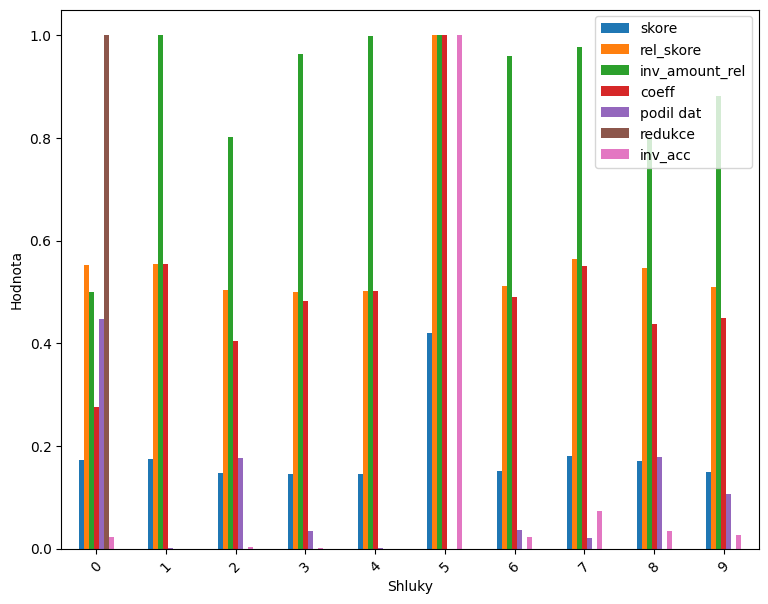

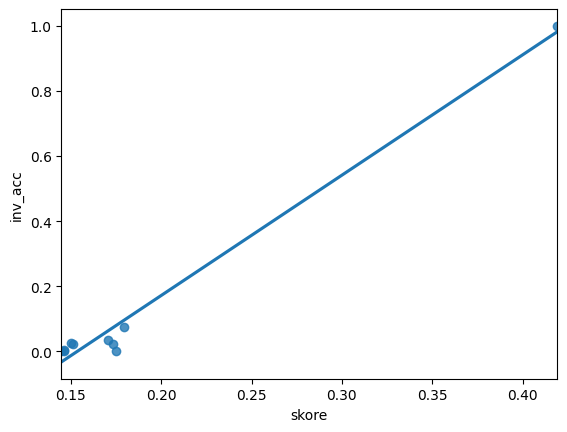

0    0.276025
1    0.554925
2    0.403628
3    0.481375
4    0.501650
5    0.999995
6    0.490782
7    0.550505
8    0.437651
9    0.449472
Name: augument, dtype: float64 --
 0    0
Name: reduction, dtype: int64
0 new data analysis
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 2034704.0974657035
Total Sum of Square Error to Grand Mean: 3277230.009340173
Between Cluster Sum of Square Error: 1242525.9118744696

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           31532   193784
    2           28977   236154
    3           2180    76045.3
    4           16

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.788326116873091
amount ratio 0.21167388312690902
inv_amount ratio 0.8054777967979055
amount ratio 0.19452220320209446
inv_amount ratio 0.9853656899271641
amount ratio 0.014634310072835902
inv_amount ratio 0.8918403651864532
amount ratio 0.1081596348135468
inv_amount ratio 0.628301950122512
amount ratio 0.371698049877488
inv_amount ratio 0.9706642499916087
amount ratio 0.029335750008391233
inv_amount ratio 0.9300238311012654
amount ratio 0.0699761688987346
AUG THRESHOLD 0.25543387119882377
RED THRESHOLD 0.29541774753737293


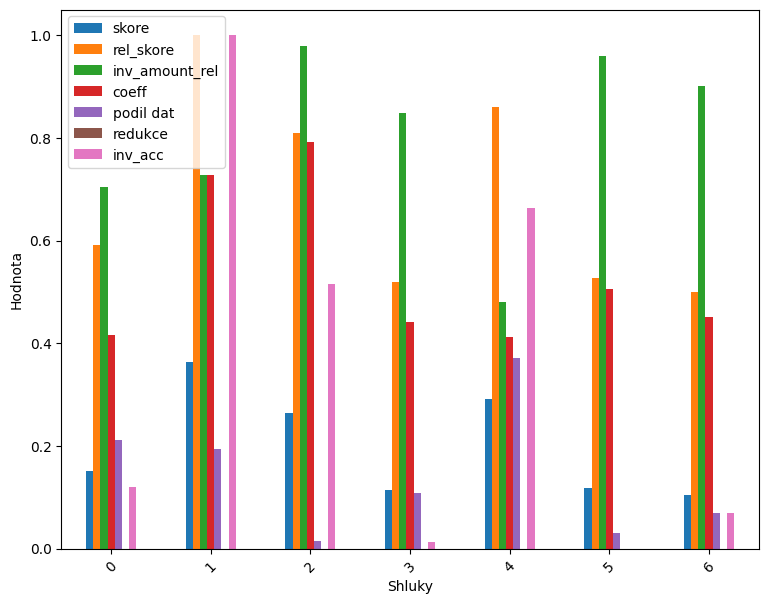

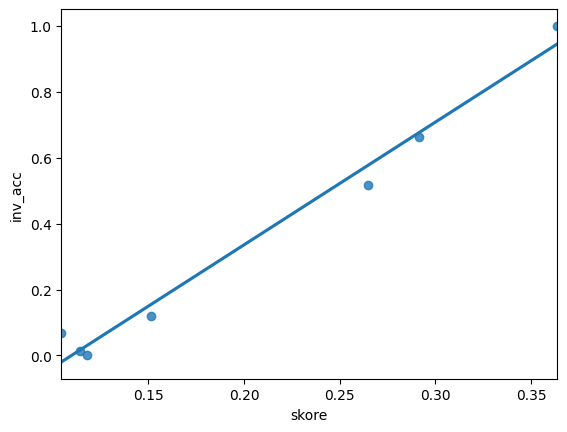

0    0.415660
1    0.727609
2    0.792424
3    0.440412
4    0.412573
5    0.504661
6    0.451006
Name: augument, dtype: float64 --
 Series([], Name: reduction, dtype: int64)
0 old data reduction
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
K ratio 10.0
Original ratio 44.737028887784795
New ratio 27.368425722194623
Reduction coef 0.6117642392511502
0 new data augument
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
POTENTIAL AMOUNT 72764
REDUCED AMOUNT 39153


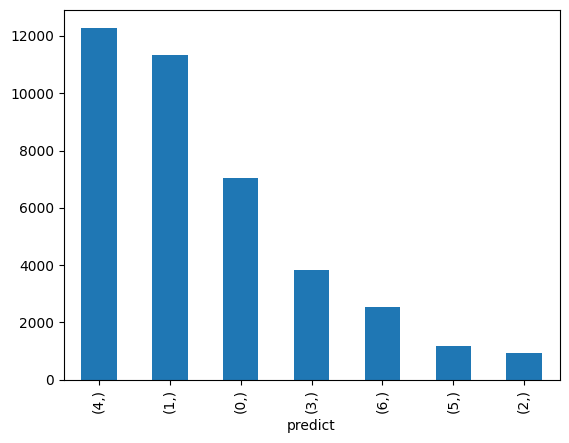

new data sampled 0
(39154, 25)
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,20 mins 28 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_netmon_775ygy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.46 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,20 mins 29 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_netmon_775ygy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.46 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


1 old data analysis
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 342142.8661694134
Total Sum of Square Error to Grand Mean: 838661.99950763
Between Cluster Sum of Square Error: 496519.13333821663

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           1689    22674
    2           13953   92488.1
    3           429     18730.1
    4           1526    31841.7
    5           4287    13855.9
    6           5633    55394.1
    7           6430    55828.5
    8           1325    8444
    9           2460    31608.6
    10          389     11277.8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.955693712127174
amount ratio 0.044306287872826
inv_amount ratio 0.6339812701660502
amount ratio 0.3660187298339498
inv_amount ratio 0.9887463602738648
amount ratio 0.011253639726135202
inv_amount ratio 0.9599695705778967
amount ratio 0.0400304294221033
inv_amount ratio 0.8875422995199497
amount ratio 0.11245770048005037
inv_amount ratio 0.852233676975945
amount ratio 0.14776632302405499
inv_amount ratio 0.8313265654101414
amount ratio 0.16867343458985862
inv_amount ratio 0.9652422549251068
amount ratio 0.034757745074893105
inv_amount ratio 0.9354686393326513
amount ratio 0.0645313606673487
inv_amount ratio 0.9897956506912201
amount ratio 0.010204349308779937
AUG THRESHOLD 0.29430569216829666
RED THRESHOLD 0.27734581988929985


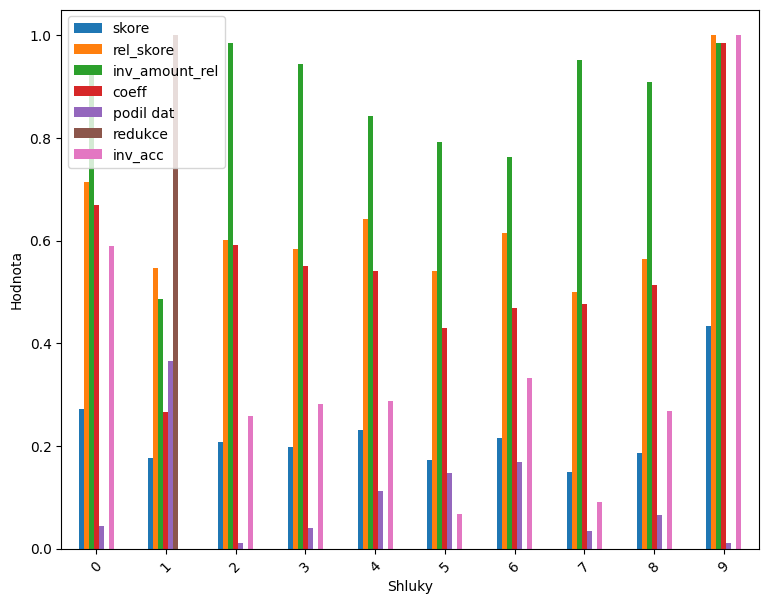

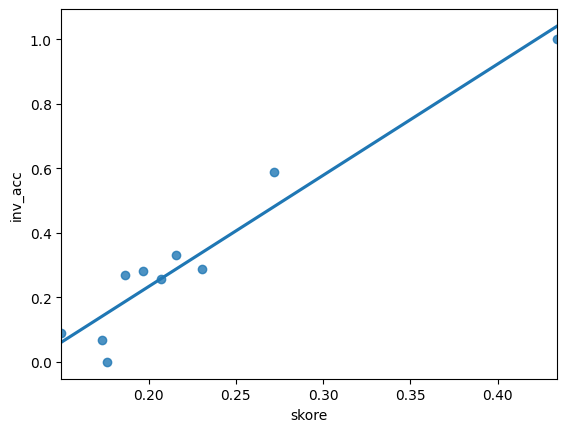

0    0.669781
1    0.265151
2    0.591262
3    0.549922
4    0.540655
5    0.428667
6    0.469348
7    0.475579
8    0.513354
9    0.985661
Name: augument, dtype: float64 --
 0    1
Name: reduction, dtype: int64
1 new data analysis
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 2020773.4241420517
Total Sum of Square Error to Grand Mean: 4261267.999624943
Between Cluster Sum of Square Error: 2240494.575482892

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           101847  951294
    2           18883   83123.3
    3           7117    185697
    4           216

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.4741860873336293
amount ratio 0.5258139126663707
inv_amount ratio 0.9025111774241845
amount ratio 0.09748882257581547
inv_amount ratio 0.963256476710688
amount ratio 0.036743523289312005
inv_amount ratio 0.9888432269455946
amount ratio 0.011156773054405402
inv_amount ratio 0.9976147944696273
amount ratio 0.0023852055303726495
inv_amount ratio 0.8133499230745402
amount ratio 0.18665007692545973
inv_amount ratio 0.8623137526201121
amount ratio 0.13768624737988786
inv_amount ratio 0.9981259099404215
amount ratio 0.0018740900595785104
inv_amount ratio 0.9997986514812023
amount ratio 0.0002013485187976912
AUG THRESHOLD 0.33917765382940074
RED THRESHOLD 0.38757964548128415


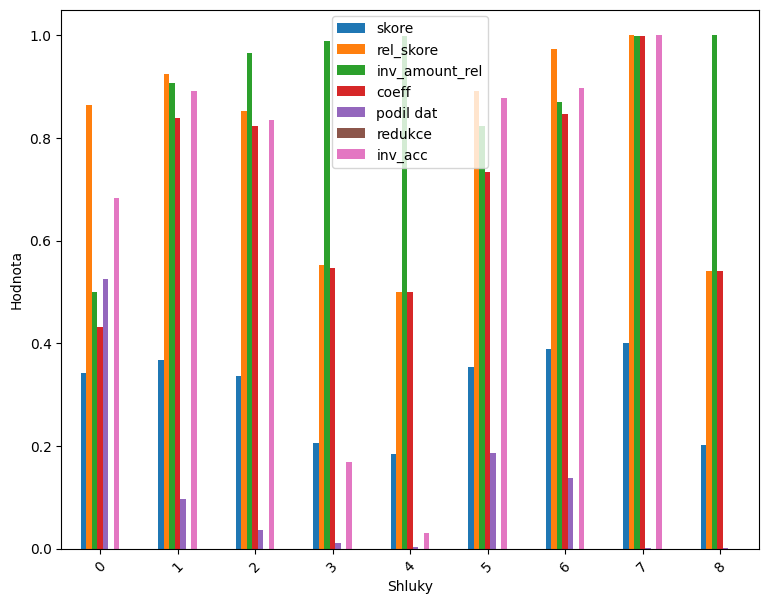

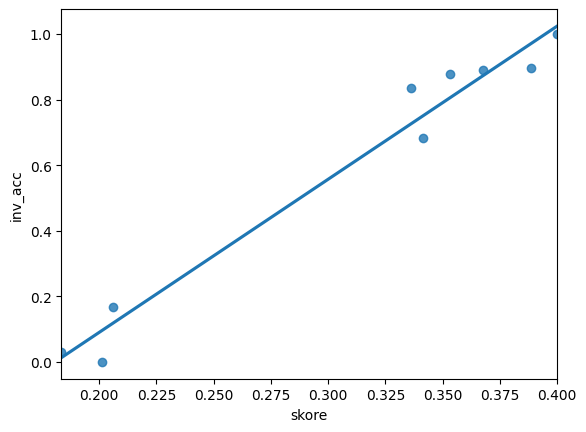

0    0.431868
1    0.839345
2    0.822739
3    0.546207
4    0.498866
5    0.733426
6    0.845919
7    0.998217
8    0.541295
Name: augument, dtype: float64 --
 Series([], Name: reduction, dtype: int64)
1 old data reduction
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
K ratio 10.0
Original ratio 36.601872983394976
New ratio 23.302116943417015
Reduction coef 0.6366050311760911
1 new data augument
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
POTENTIAL AMOUNT 116558
REDUCED AMOUNT 5070


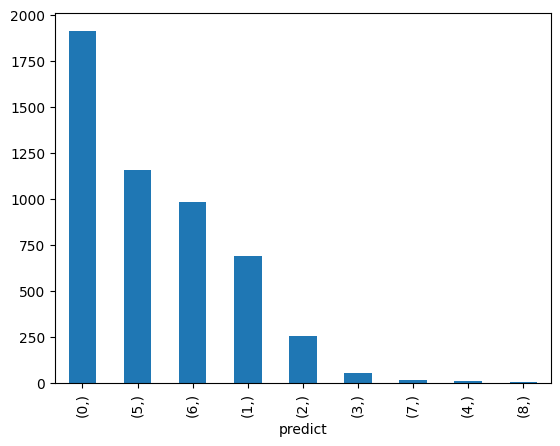

new data sampled 1
(5069, 25)
        bytes_rev   bytes  packets  packets_rev  packets_sum  bytes_ration  \
0            5869    2399       16           10           26      0.408758   
1           26798    2052       23           26           49      0.076573   
3         1608147    9880      126          200          326      0.006144   
5            4387    1631       12            7           19      0.371780   
7            3332    2140       12           10           22      0.642257   
...           ...     ...      ...          ...          ...           ...   
115678         40     468        9            1           10     11.700000   
23576          64    1220        9            1           10     19.062500   
77534          52    1220        9            1           10     23.461538   
101269         52    1216       10            1           11     23.384615   
164568     442840  257415     2131         2040         4171      0.581282   

        num_pkts_ration        ti

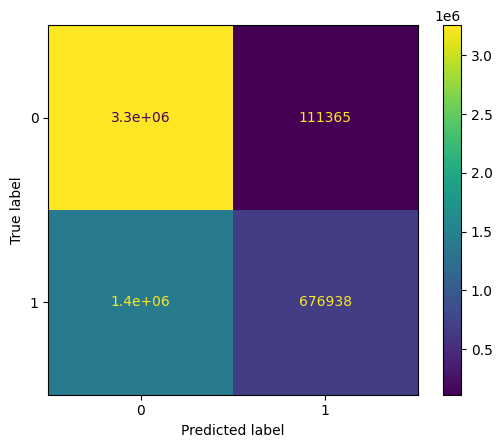

              precision    recall  f1-score   support

           0     0.7608    0.9793    0.8564   3369502
           1     0.9378    0.5028    0.6547   2086340

    accuracy                         0.7971   5455842
   macro avg     0.8493    0.7411    0.7555   5455842
weighted avg     0.8285    0.7971    0.7792   5455842



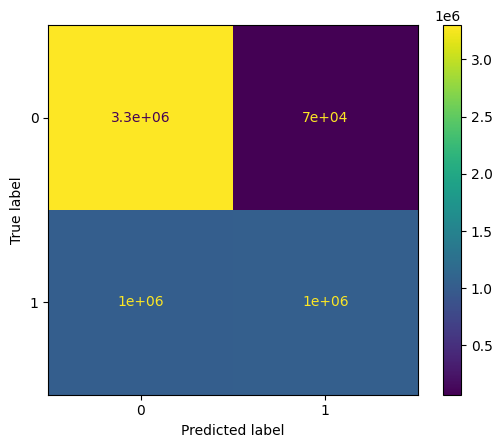

Improvement 30.830414992663275


In [76]:
# reduce all classes
def modification(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    balance_old=old_data.class_balance(old_data.csv_data[old_data.label])
    print(balance_old)
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model_old=H2O_model(old_data,clf_dumb,label)
            cluster_model_new=H2O_model(new_data,clf_old,label)
        else:
            cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
            cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric)

        print(label,"old data analysis")
        cluster_model_old.cluster_analysis(pca=True)

        print(label,"new data analysis")
        cluster_model_new.cluster_analysis(pca=True)

        if reduction_style=='uni':
            print(label,"old data reduction")
            reduced_amount=old_data.reduce(cluster_model_old,1/cluster_model_old.size)
            print(label,"new data augument")
            new_data.augument_coeff(cluster_model_new,reduced_amount,'all')
        else:
            print(label,"old data reduction")
            reduced_amount=old_data.reduce(cluster_model_old)
            print(label,"new data augument")
            new_data.augument_coeff(cluster_model_new,reduced_amount,'all')
        
        # balance_new=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
        # print(balance_old,balance_new)
        # space_to_aug=balance_old[label]-balance_new[label]
        # balance_aug=new_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True))
        # ratio=space_to_aug/balance_aug[label]
        
        # aug_data=new_data.newdata[new_data.newdata[new_data.label]==label].drop(columns=['predict'])
        # labels=new_data.newdata[new_data.newdata[new_data.label]==label].pop('predict')
        
        # print(ratio)
        # #print(aug_data)
        # print(labels)
        # if ratio > 1:
        #     old_data.newdata=pd.concat([old_data.newdata,aug_data])
        # else:
        #     aug_data, _, _, _ =train_test_split(aug_data, labels, test_size=1-ratio, random_state=42, shuffle=True, stratify=labels)
        #     old_data.newdata=pd.concat([old_data.newdata,aug_data])
    old_data.newdata=pd.concat([old_data.newdata,new_data.newdata])
    print(old_data.newdata)

for alg in ['h2o']:#h2o,aglomerative
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for reduction_style in ['avg']:#uni
            print(reduction_style)
            
            modification(metric=metric,alg=alg, reduction_style=reduction_style)
            
            clf_reduced=AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
                )
            clustered_result=old_data.compare_models(clf_old,clf_reduced,test_data)
            tmp=old_data.prepare_model_result(clustered_result,text+'_'+reduction_style,use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            balance=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
            sampling_ratio=balance[1]/balance[0]
            balance_dict={0:balance[0],1:balance[1]}
            old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
            old_data.set_newdata()
            new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
            new_data.set_newdata()


In [ ]:
framework_result

In [256]:
framework_result.to_csv(f"xsetin00/{use_case}_aging_comparation.csv",mode='a',index=False)

# DoH data

DOH
({1: 1936940}, {0: 1489653}, 3426593)

aglomerative
bouldin
avg
(7448, 21)


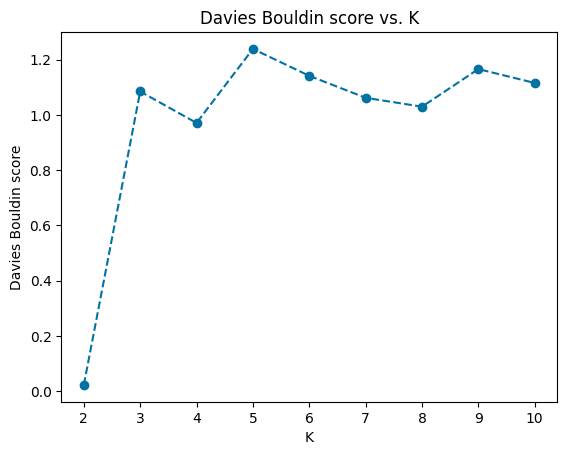

Final K parameter: 2


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.013426423200854742
amount ratio 99.98657357679915
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
AUG THRESHOLD 37.25403632808525
RED THRESHOLD 83.32438238453277


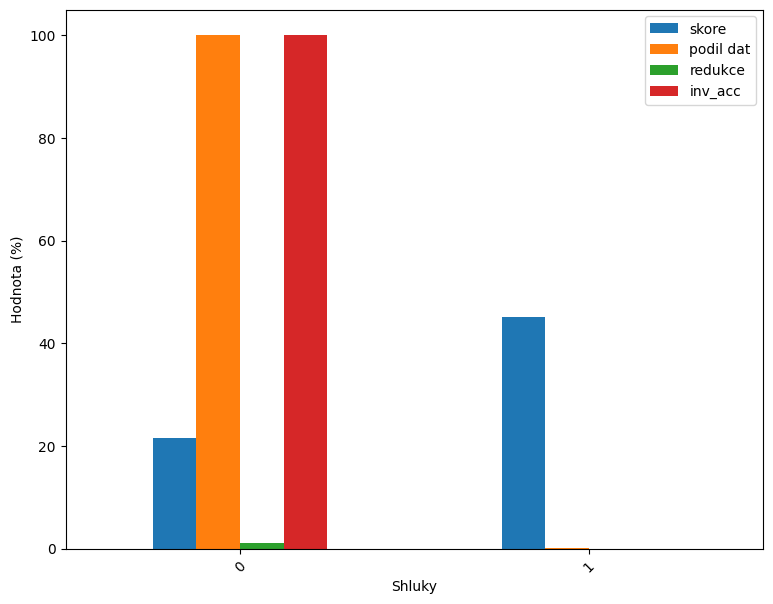

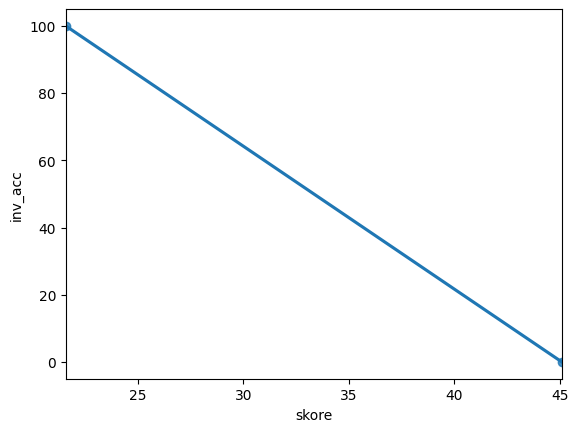

0    1
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 50.0
Original ratio 99.98657357679915
New ratio 75.0
Reduction coef 0.7500335705653283
(9684, 21)


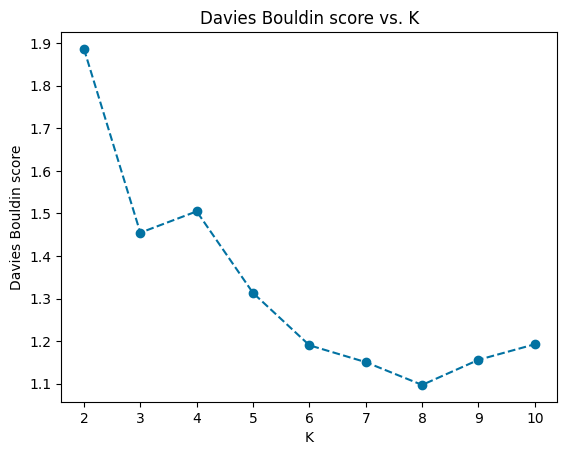

Final K parameter: 8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 63.10408921933085
amount ratio 36.89591078066915
inv_amount ratio 72.79016935150764
amount ratio 27.209830648492357
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
inv_amount ratio 99.76249483684428
amount ratio 0.23750516315572076
inv_amount ratio 82.25939694341182
amount ratio 17.740603056588185
inv_amount ratio 98.55431639818256
amount ratio 1.4456836018174308
inv_amount ratio 94.87814952498968
amount ratio 5.121850475010326
AUG THRESHOLD 48.9022488719037
RED THRESHOLD 28.7639405204461


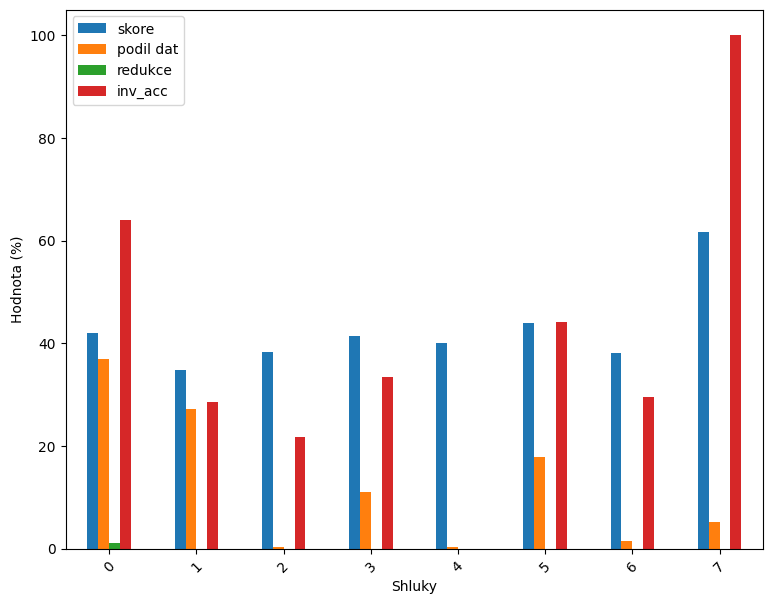

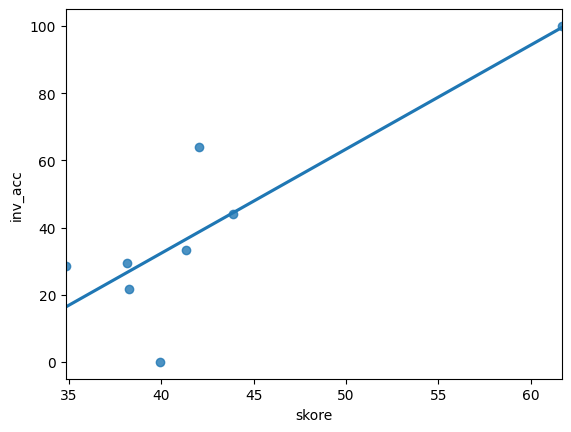

0    7
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 12.5
Original ratio 36.89591078066915
New ratio 24.70053696819496
Reduction coef 0.6693954659949622
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 8503}, {0: 5587}, 14090)
Reduction ratio 17.75624562222741
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



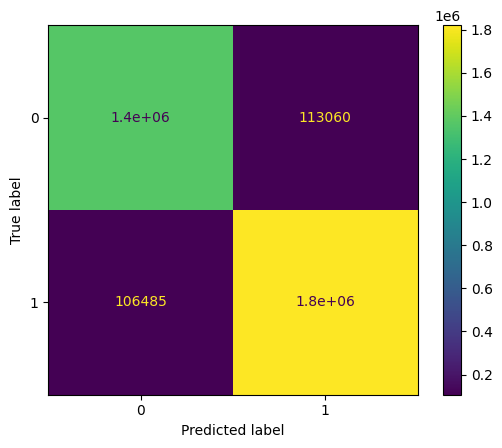

              precision    recall  f1-score   support

           0     0.9294    0.9162    0.9227   1482205
           1     0.9362    0.9465    0.9413   1927256

    accuracy                         0.9333   3409461
   macro avg     0.9328    0.9313    0.9320   3409461
weighted avg     0.9333    0.9333    0.9332   3409461



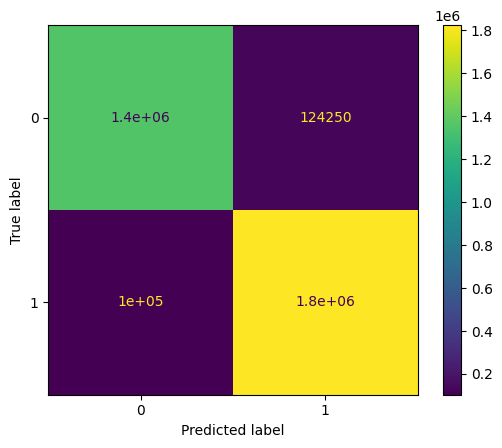

Improvement -3.6343492456281123
uni
(7448, 21)


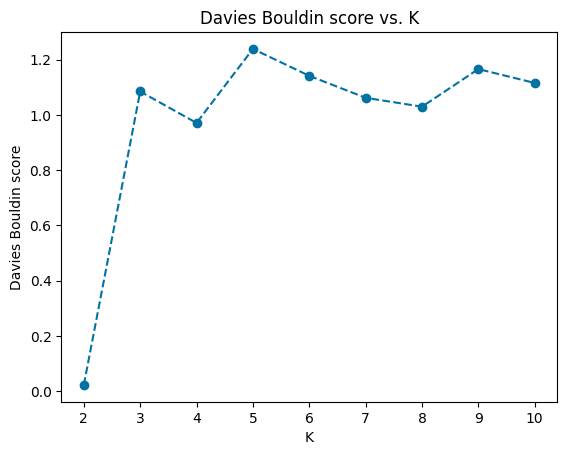

Final K parameter: 2


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.013426423200854742
amount ratio 99.98657357679915
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
AUG THRESHOLD 37.25403632808525
RED THRESHOLD 83.32438238453277


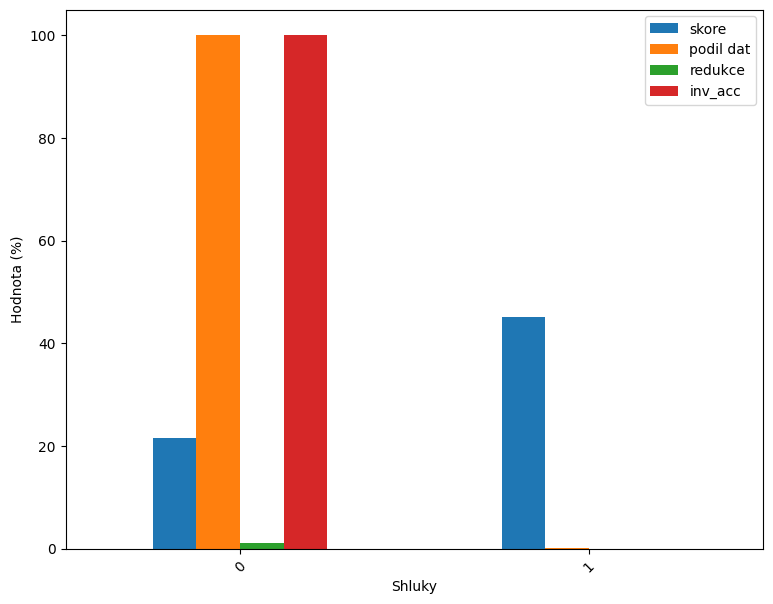

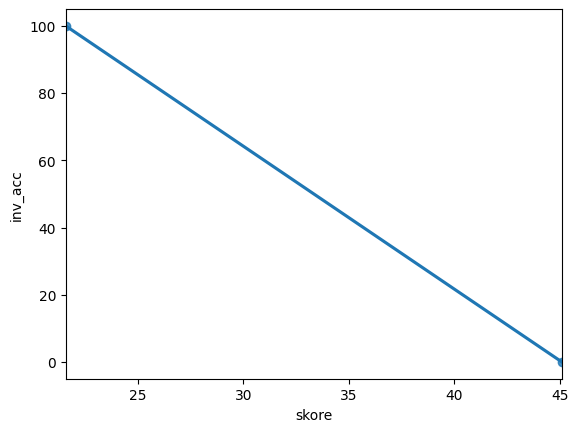

0    1
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 50.0
Original ratio 99.98657357679915
New ratio 50.0
Reduction coef 0.5000671411306566
(9684, 21)


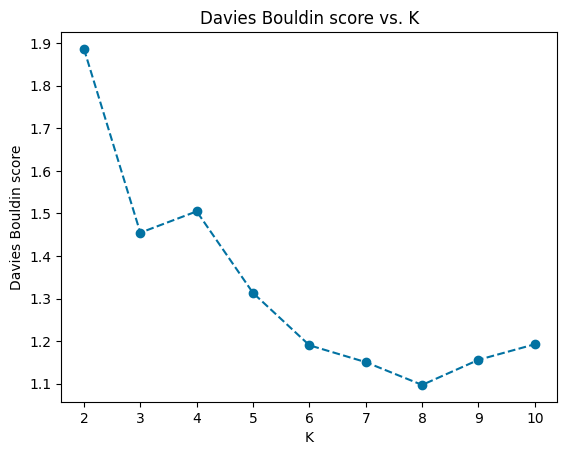

Final K parameter: 8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 63.10408921933085
amount ratio 36.89591078066915
inv_amount ratio 72.79016935150764
amount ratio 27.209830648492357
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
inv_amount ratio 99.76249483684428
amount ratio 0.23750516315572076
inv_amount ratio 82.25939694341182
amount ratio 17.740603056588185
inv_amount ratio 98.55431639818256
amount ratio 1.4456836018174308
inv_amount ratio 94.87814952498968
amount ratio 5.121850475010326
AUG THRESHOLD 48.9022488719037
RED THRESHOLD 28.7639405204461


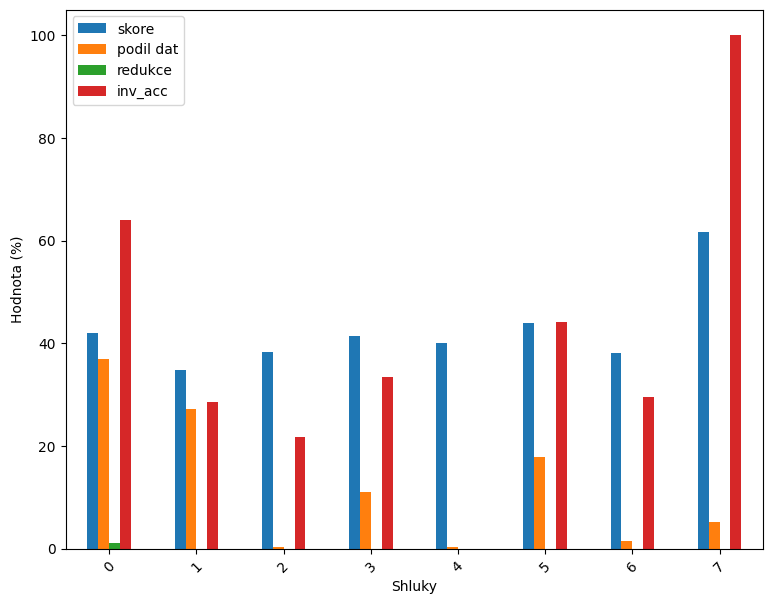

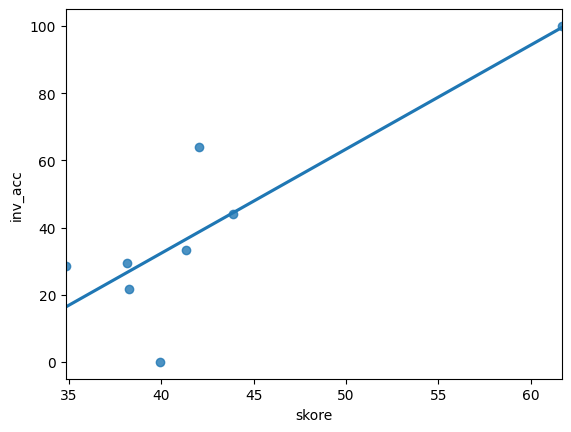

0    7
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 12.5
Original ratio 36.89591078066915
New ratio 12.494836844279224
Reduction coef 0.33879093198992444
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 7321}, {0: 3725}, 11046)
Reduction ratio 35.52416530469297
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



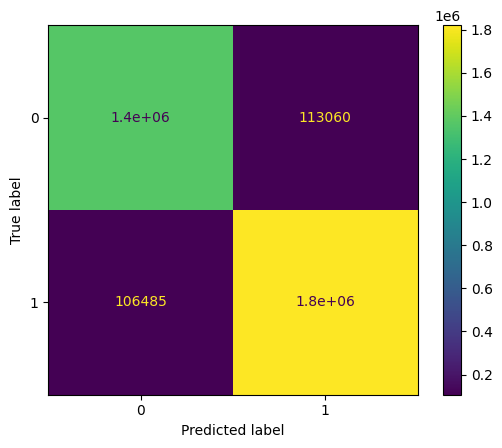

              precision    recall  f1-score   support

           0     0.9181    0.9089    0.9135   1482205
           1     0.9305    0.9376    0.9340   1927256

    accuracy                         0.9251   3409461
   macro avg     0.9243    0.9233    0.9237   3409461
weighted avg     0.9251    0.9251    0.9251   3409461



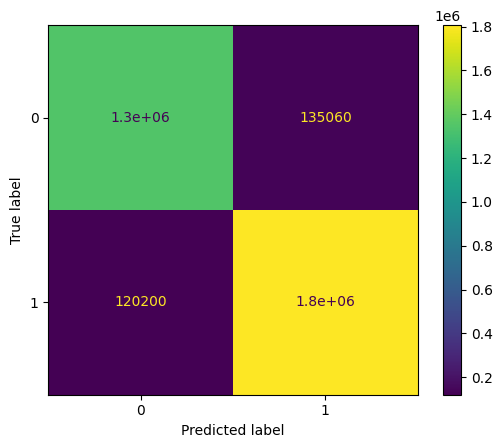

Improvement -16.307117908258473
elbow
avg
(7448, 21)


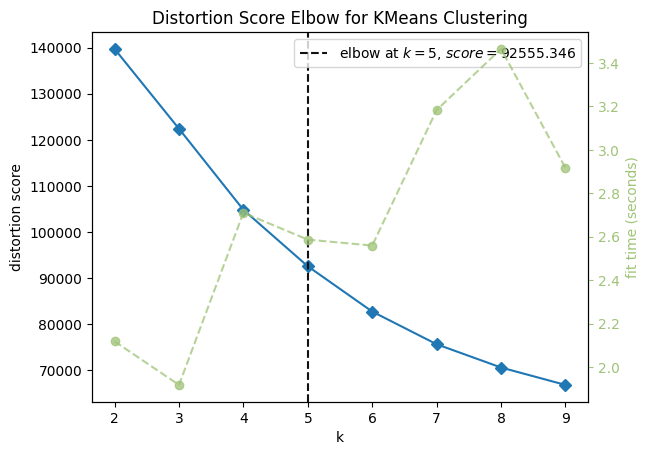

Final K parameter: 5


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 29.1890440386681
amount ratio 70.8109559613319
inv_amount ratio 89.39312567132116
amount ratio 10.60687432867884
inv_amount ratio 83.8077336197637
amount ratio 16.192266380236305
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
inv_amount ratio 97.6235230934479
amount ratio 2.3764769065520945
AUG THRESHOLD 39.92723832682719
RED THRESHOLD 53.87397064088793


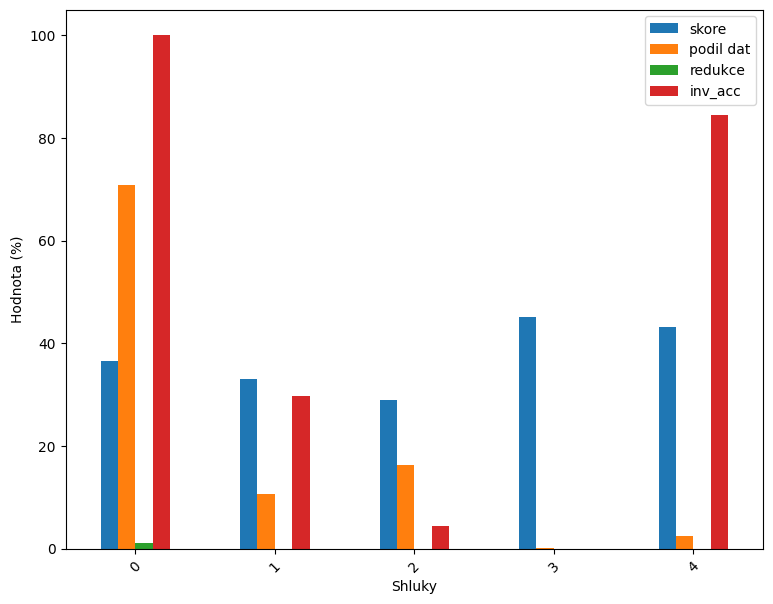

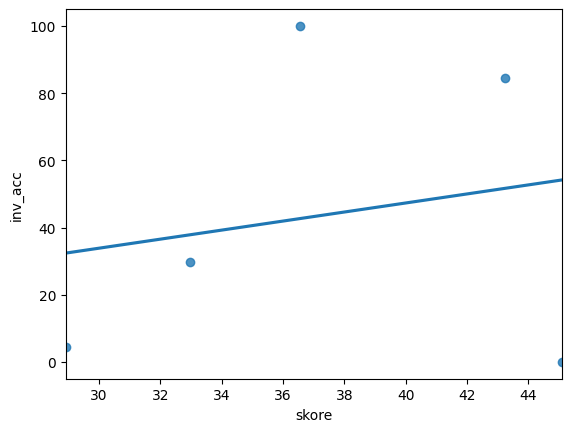

0    3
1    4
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 20.0
Original ratio 70.8109559613319
New ratio 45.40816326530612
Reduction coef 0.6412210845657945
(9684, 21)


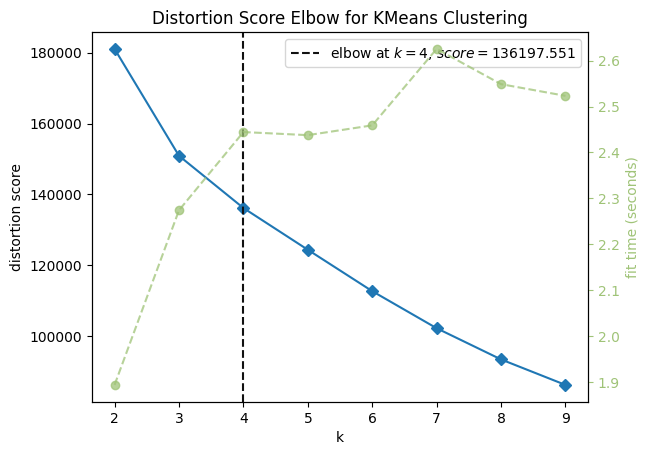

Final K parameter: 4


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 65.98513011152417
amount ratio 34.014869888475836
inv_amount ratio 45.363486162742674
amount ratio 54.636513837257326
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
AUG THRESHOLD 40.49457895702892
RED THRESHOLD 44.75767589150488


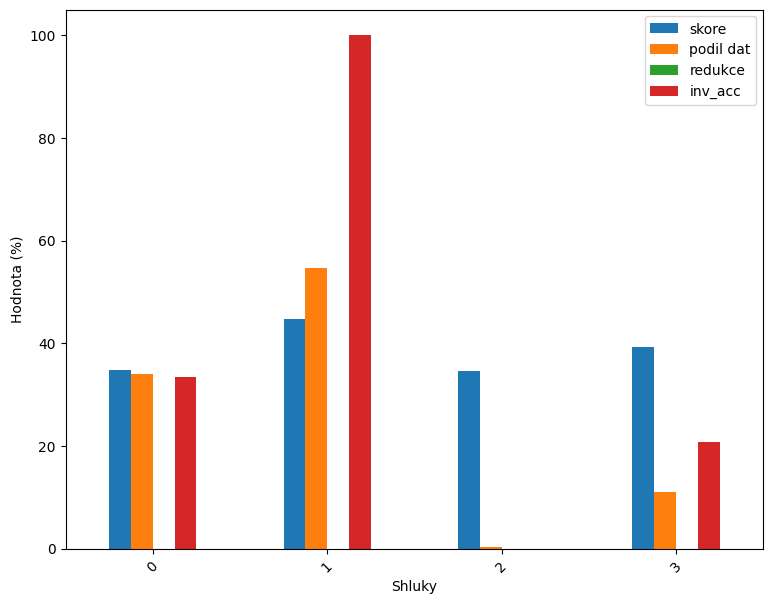

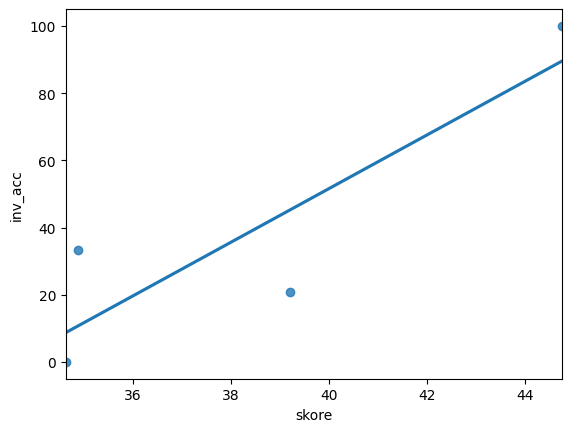

0    1
Name: augument, dtype: int64 --
 Series([], Name: reduction, dtype: int64)
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 9684}, {0: 5556}, 15240)
Reduction ratio 11.043660985290686
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



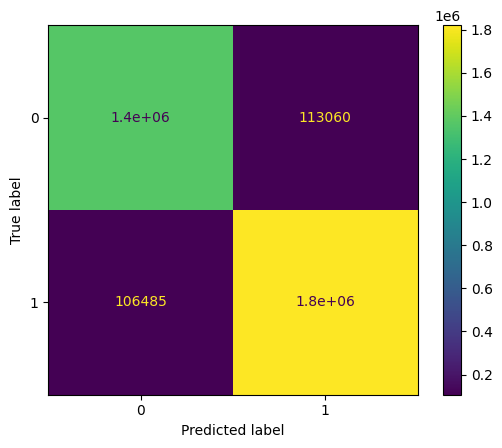

              precision    recall  f1-score   support

           0     0.9378    0.9027    0.9199   1482205
           1     0.9272    0.9540    0.9404   1927256

    accuracy                         0.9317   3409461
   macro avg     0.9325    0.9283    0.9302   3409461
weighted avg     0.9318    0.9317    0.9315   3409461



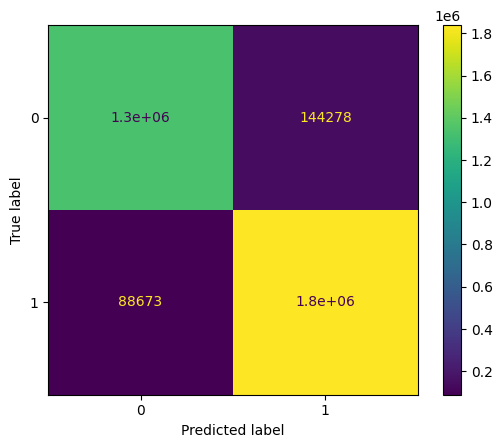

Improvement -6.338326888124703
uni
(7448, 21)


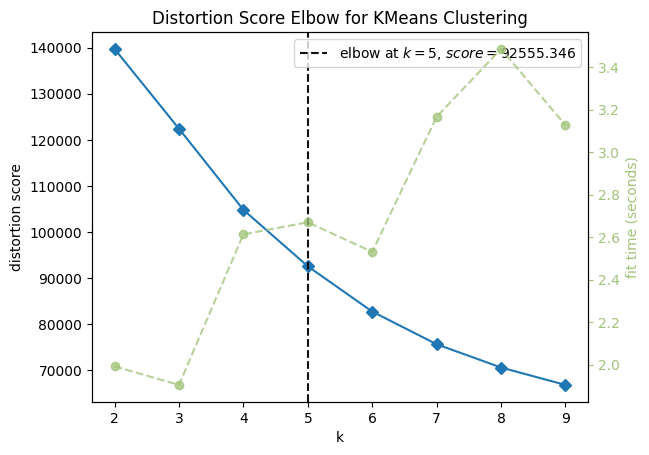

Final K parameter: 5


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 29.1890440386681
amount ratio 70.8109559613319
inv_amount ratio 89.39312567132116
amount ratio 10.60687432867884
inv_amount ratio 83.8077336197637
amount ratio 16.192266380236305
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
inv_amount ratio 97.6235230934479
amount ratio 2.3764769065520945
AUG THRESHOLD 39.92723832682719
RED THRESHOLD 53.87397064088793


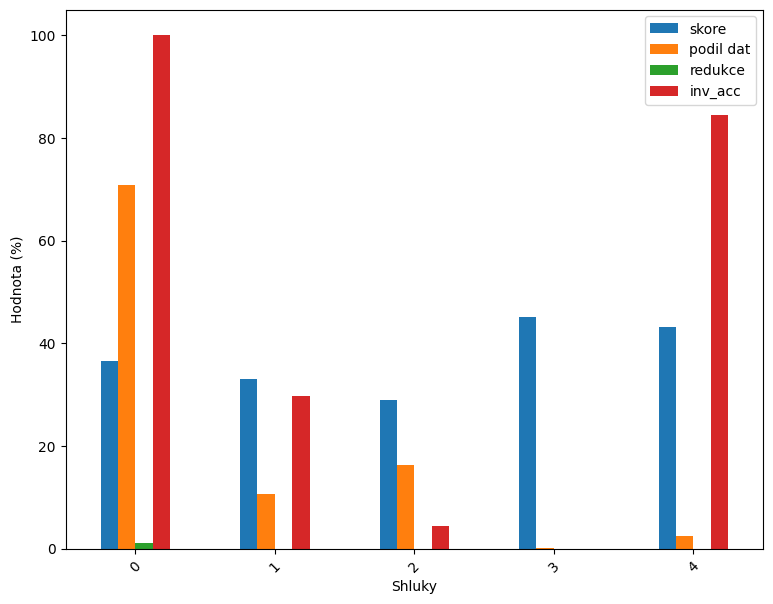

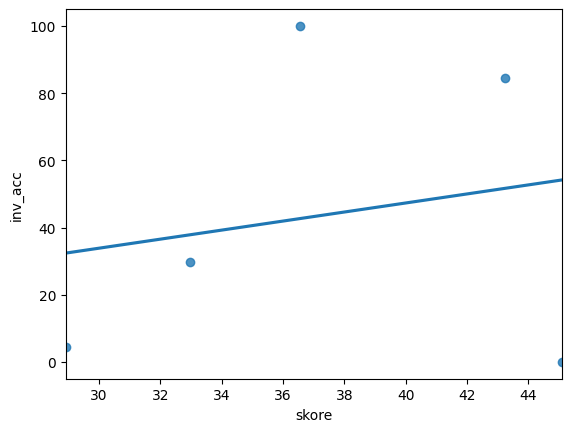

0    3
1    4
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 20.0
Original ratio 70.8109559613319
New ratio 20.00537056928034
Reduction coef 0.2824421691315889
(9684, 21)


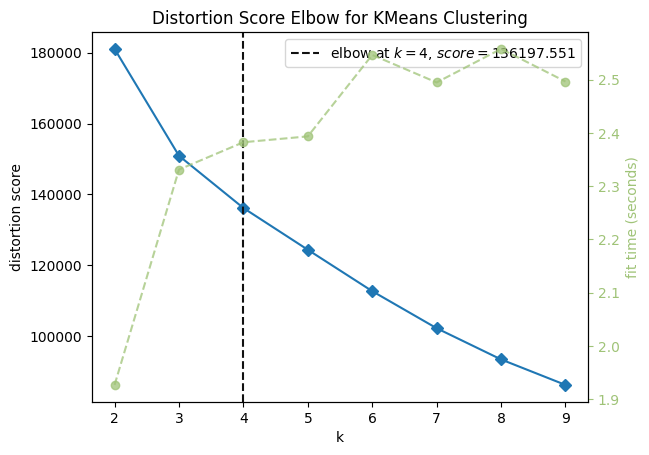

Final K parameter: 4


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 65.98513011152417
amount ratio 34.014869888475836
inv_amount ratio 45.363486162742674
amount ratio 54.636513837257326
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
AUG THRESHOLD 40.49457895702892
RED THRESHOLD 44.75767589150488


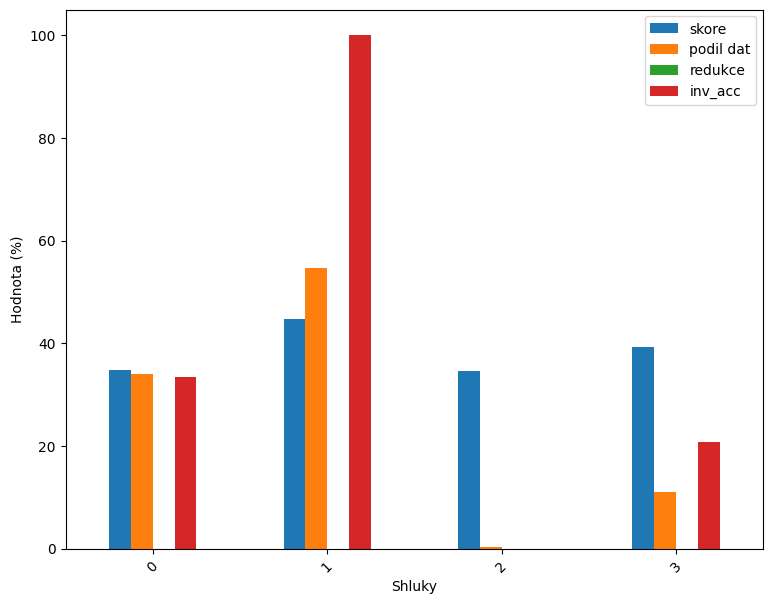

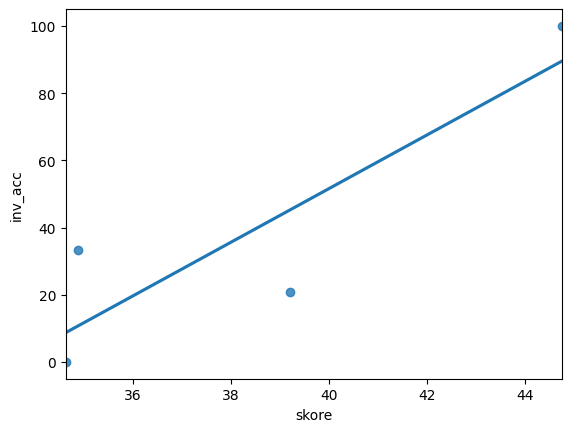

0    1
Name: augument, dtype: int64 --
 Series([], Name: reduction, dtype: int64)
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 9684}, {0: 3664}, 13348)
Reduction ratio 22.08732197058137
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



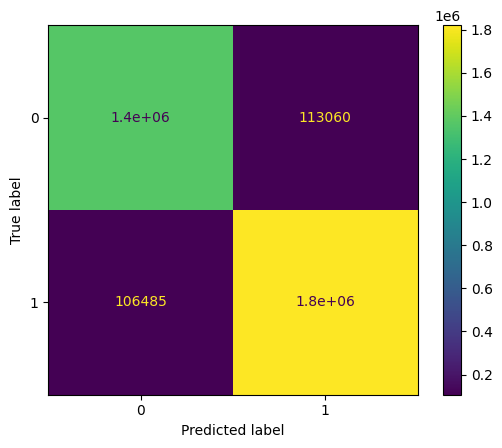

              precision    recall  f1-score   support

           0     0.9542    0.8561    0.9025   1482205
           1     0.8974    0.9684    0.9316   1927256

    accuracy                         0.9196   3409461
   macro avg     0.9258    0.9122    0.9170   3409461
weighted avg     0.9221    0.9196    0.9189   3409461



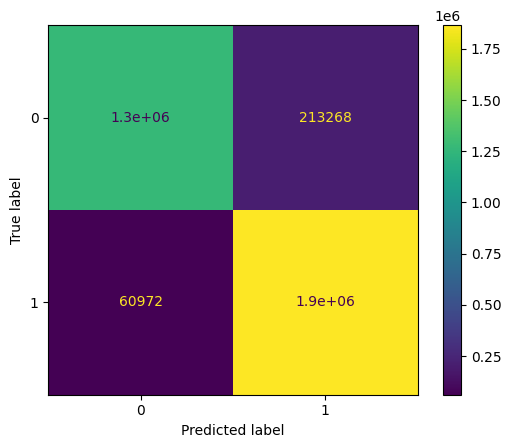

Improvement -25.888690625668893


In [111]:
use_case="DOH"
label="is_doh"
class_values=(True,False)
framework_result=pd.DataFrame()
filename="doh_test_analyze_3M.csv"#"doh_train_old+new.csv"

train_data=Modifier(f"{filename}",label,use_case,class_values)
train_data.load()
print(use_case)
print(train_data.class_balance(train_data.csv_data[label]))
#print(train_data.csv_data)
print()
clf=DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.995, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
original_result=classification_report(y_test,pred,digits=4,output_dict=True)
train_data.cnt_new=train_data.class_balance(y_train)
tmp=train_data.prepare_model_result(original_result,'original',use_case)
framework_result=pd.concat([framework_result,tmp])
# metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
# plt.show()
train_data.set_data(pd.concat([X_train,y_train],axis=1))
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf_dumb=DecisionTreeClassifier(random_state=42)
clf_dumb.fit(dumb_X_train, dumb_y_train)

# reduce all classes
def reduction(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model=H2O_model(train_data,clf_dumb,label)
        else:
            cluster_model=Sklearn_model(train_data,clf_dumb,label,model=alg,index=metric)

        cluster_model.cluster_analysis(pca=True)
        if reduction_style=='uni':
            train_data.reduce(cluster_model,1/cluster_model.size)
        else:
            train_data.reduce(cluster_model)

for alg in ['aglomerative']:#h2o
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin','elbow']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for reduction_style in ['avg','uni']:
            print(reduction_style)
            
            reduction(metric=metric,alg=alg, reduction_style=reduction_style)

            clf_new=DecisionTreeClassifier(random_state=42)
            clustered_result=train_data.compare_models(clf,clf_new,test_data)
            tmp=train_data.prepare_model_result(clustered_result,'clustering_'+reduction_style,use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
            sampling_ratio=balance[0][1]/balance[1][0]
            balance_dict={0:balance[1][0],1:balance[0][1]}
            train_data.set_data(pd.concat([X_train,y_train],axis=1))
            train_data.set_newdata()



In [69]:
balance_dict#={1:5901,0:5129}

{1: 5901, 0: 5129}

In [112]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.000000,"9684,7448"
0,DOH,clusteringavg,aglomerativebouldin,0.933307,0.933265,0.933307,0.933250,-3.634349,"8503,5587"
0,DOH,clusteringuni,aglomerativebouldin,0.925132,0.925078,0.925132,0.925087,-16.307118,"7321,3725"
0,DOH,clusteringavg,aglomerativeelbow,0.931675,0.931848,0.931675,0.931508,-6.338327,"9684,5556"
0,DOH,clusteringuni,aglomerativeelbow,0.919565,0.922098,0.919565,0.918916,-25.888691,"9684,3664"


In [83]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.000000,"9684,7448"
0,DOH,clustering_uniform,aglo,0.931675,0.931848,0.931675,0.931508,-6.338327,"9684,5556"


### IMBL 

In [113]:
imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
      #(NearMiss(sampling_strategy=balance_dict,version=2),"near_miss2"),
      #(NearMiss(sampling_strategy=balance_dict,version=3),"near_miss3"),
      #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
      #(EditedNearestNeighbours(),"edited_NN"),
      #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
      #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),
      #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
      #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
      #(RandomUnderSampler(sampling_strategy=balance_dict,random_state=42),"random_sampler"),
      #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
      #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42),"cluster_centroids"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
      ]
overall_result=framework_result
for sampler in imbl:
  print(sampler[1])
  train_data.apply_imbalanced_lib(sampler[0])
  imbl_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(imbl_result,sampler[1],use_case)
  overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)

  Dataset         Method               Metric       Acc  Precision    Recall  \
0     DOH       original              default  0.935607   0.935581  0.935607   
1     DOH  clusteringavg  aglomerativebouldin  0.933307   0.933265  0.933307   
2     DOH  clusteringuni  aglomerativebouldin  0.925132   0.925078  0.925132   
3     DOH  clusteringavg    aglomerativeelbow  0.931675   0.931848  0.931675   
4     DOH  clusteringuni    aglomerativeelbow  0.919565   0.922098  0.919565   

         F1       Impr    Support  
0  0.935590   0.000000  9684,7448  
1  0.933250  -3.634349  8503,5587  
2  0.925087 -16.307118  7321,3725  
3  0.931508  -6.338327  9684,5556  
4  0.918916 -25.888691  9684,3664  


In [114]:
overall_result.to_csv(f"{use_case}_comparation.csv",mode='a',index=False)

# Adasyn data

diabetes.csv
({1: 268}, {0: 500}, 768)

(250, 8)
CRIT 0.0990625
SSE 1660.7357698028668


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1333.2058252322868
PRE 0.1972197808501822 2


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1108.8436295563995
PRE 0.16828774029456123 3


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 969.5073811833315
PRE 0.1256590601767811 4
SSE 871.0884364408246
PRE 0.10151438416320438

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 5


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 772.8856084126862
PRE 0.11273577276422672 6
SSE 702.9753820969485
PRE 0.09045352320547911 7
Final K parameter: 6
SSE 772.8856084126862


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


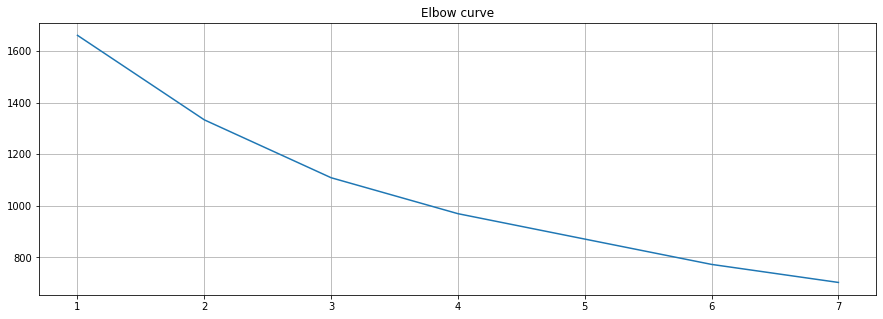

inv_amount ratio 70.4
amount ratio 29.599999999999998
inv_amount ratio 72.0
amount ratio 28.000000000000004
inv_amount ratio 86.8
amount ratio 13.200000000000001
inv_amount ratio 88.8
amount ratio 11.200000000000001
inv_amount ratio 85.6
amount ratio 14.399999999999999
inv_amount ratio 96.4
amount ratio 3.5999999999999996
AUG THRESHOLD 44.9687580588542
RED THRESHOLD 25.288888888888888


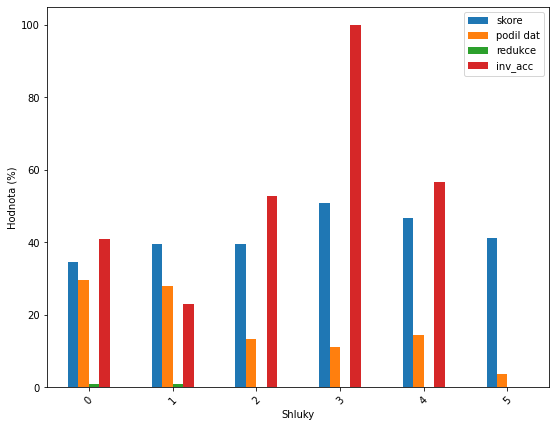

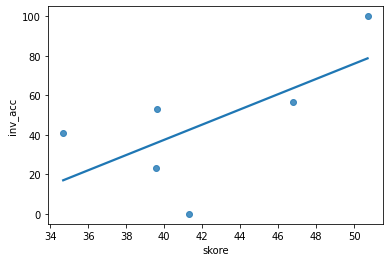

0    3
1    4
Name: augument, dtype: int64 --
 0    0
1    1
Name: reduction, dtype: int64
K ratio 16.666666666666668
Original ratio 29.599999999999998
New ratio 16.8
Reduction coef 0.5630630630630631
K ratio 16.666666666666668
Original ratio 28.000000000000004
New ratio 16.8
Reduction coef 0.5952380952380951
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



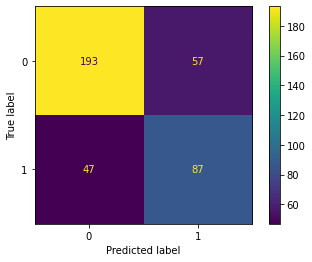

              precision    recall  f1-score   support

           0     0.7960    0.7960    0.7960       250
           1     0.6194    0.6194    0.6194       134

    accuracy                         0.7344       384
   macro avg     0.7077    0.7077    0.7077       384
weighted avg     0.7344    0.7344    0.7344       384



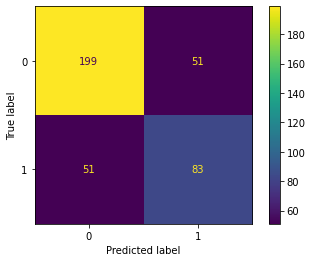

Improvement 1.153903066451125
near_miss1
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



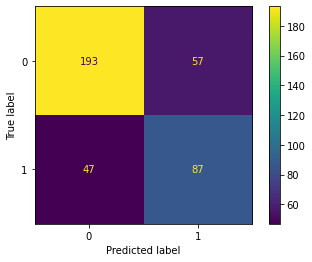

              precision    recall  f1-score   support

           0     0.7900    0.6920    0.7377       250
           1     0.5333    0.6567    0.5886       134

    accuracy                         0.6797       384
   macro avg     0.6616    0.6744    0.6632       384
weighted avg     0.7004    0.6797    0.6857       384



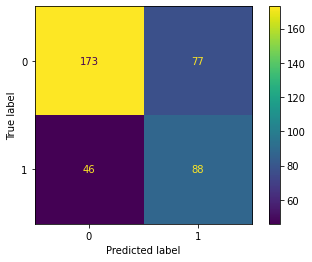

Improvement -16.957006170996923
near_miss2
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



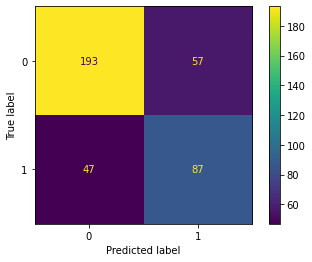

              precision    recall  f1-score   support

           0     0.7679    0.7280    0.7474       250
           1     0.5374    0.5896    0.5623       134

    accuracy                         0.6797       384
   macro avg     0.6527    0.6588    0.6549       384
weighted avg     0.6875    0.6797    0.6828       384



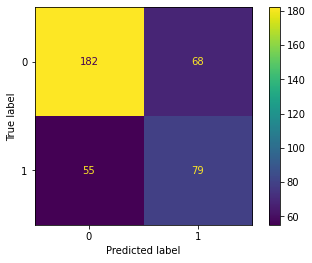

Improvement -18.030465331640237
random_sampler
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



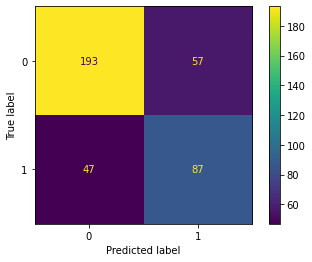

              precision    recall  f1-score   support

           0     0.7909    0.6960    0.7404       250
           1     0.5366    0.6567    0.5906       134

    accuracy                         0.6823       384
   macro avg     0.6637    0.6764    0.6655       384
weighted avg     0.7022    0.6823    0.6881       384



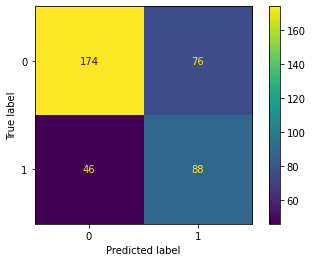

Improvement -16.0498505951066
cluster_centroids


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



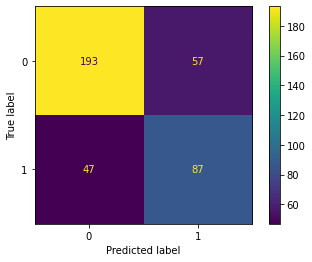

              precision    recall  f1-score   support

           0     0.8136    0.7160    0.7617       250
           1     0.5671    0.6940    0.6242       134

    accuracy                         0.7083       384
   macro avg     0.6904    0.7050    0.6929       384
weighted avg     0.7276    0.7083    0.7137       384



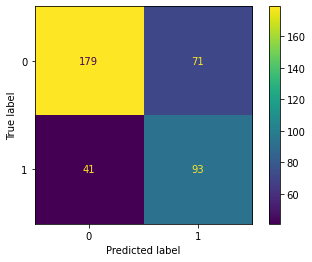

Improvement -6.537567759442138
cluster_centroids_est_k


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



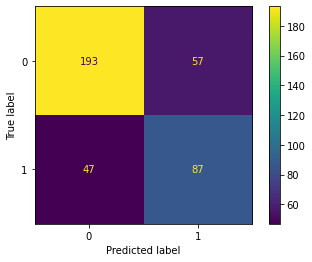

              precision    recall  f1-score   support

           0     0.7773    0.7400    0.7582       250
           1     0.5548    0.6045    0.5786       134

    accuracy                         0.6927       384
   macro avg     0.6661    0.6722    0.6684       384
weighted avg     0.6997    0.6927    0.6955       384



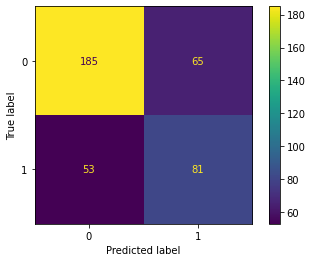

Improvement -13.306940035013392
    Dataset                   Method       Acc  Precision    Recall        F1  \
0  diabetes                 original  0.729167   0.734375  0.729167  0.731274   
1  diabetes               clustering  0.734375   0.734375  0.734375  0.734375   
2  diabetes               near_miss1  0.679688   0.700404  0.679688  0.685706   
3  diabetes               near_miss2  0.679688   0.687491  0.679688  0.682822   
4  diabetes           random_sampler  0.682292   0.702161  0.682292  0.688144   
5  diabetes        cluster_centroids  0.708333   0.727596  0.708333  0.713706   
6  diabetes  cluster_centroids_est_k  0.692708   0.699662  0.692708  0.695515   

        Impr  Support  
0   0.000000  134,250  
1   1.153903  134,190  
2 -16.957006  134,190  
3 -18.030465  134,190  
4 -16.049851  134,190  
5  -6.537568  134,190  
6 -13.306940  134,190  


In [ ]:
names=["diabetes.csv"]#,"abalone.csv","vowel.csv","ionosphere.csv","vehicle.csv"]

use_case="Adasyn"
label="Class"
class_values=(1,0)
overall_result=pd.DataFrame()
for name in names:
  train_data=Modifier(f"/content/drive/My Drive/Cluster/{use_case}/{name}",label,use_case,class_values)
  train_data.load()
  print(name)
  print(train_data.class_balance(train_data.csv_data[label]))
  #print(train_data.csv_data)
  print()
  clf=DecisionTreeClassifier(random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.5, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf.fit(X_train,y_train)
  pred = clf.predict(X_test)
  original_result=classification_report(y_test,pred,digits=4,output_dict=True)
  train_data.cnt_new=train_data.class_balance(y_train)
  tmp=train_data.prepare_model_result(original_result,'original',name[:-4])
  overall_result=pd.concat([overall_result,tmp])
  # metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
  # plt.show()
  train_data.set_data(pd.concat([X_train,y_train],axis=1))
  test_data=Dataset(_,label,use_case,class_values)
  test_data.set_data(pd.concat([X_test,y_test],axis=1))

  # just small sample to train classifier
  dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf_dumb=DecisionTreeClassifier(random_state=42)
  clf_dumb.fit(dumb_X_train, dumb_y_train)

  cluster_model=Sklearn_model(train_data,clf_dumb,0)
  cluster_model.cluster_analysis(pca=True)
  train_data.reduce(cluster_model,1/cluster_model.size)
  train_data.set_class(1)
  minority_data=pd.concat([train_data.X,train_data.y],axis=1)
  train_data.newdata=pd.concat([train_data.newdata,minority_data])
  clf_new=DecisionTreeClassifier(random_state=42)
  clustered_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(clustered_result,'clustering',name[:-4])
  overall_result=pd.concat([overall_result,tmp])

  balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
  sampling_ratio=balance[0][1]/balance[1][0]
  balance_dict={0:balance[1][0],1:balance[0][1]}
  imbl=[(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
        (NearMiss(sampling_strategy=sampling_ratio,version=2),"near_miss2"),
        #(NearMiss(sampling_strategy=sampling_ratio,version=3),"near_miss3"),
        # (CondensedNearestNeighbour(random_state=42),"condensed_NN"),
        # (EditedNearestNeighbours(),"edited_NN"),
        # (RepeatedEditedNearestNeighbours(),"rep_edited__NN"),
        # (InstanceHardnessThreshold(sampling_strategy=sampling_ratio,random_state=42),"inst_hard_tresh"),
        # (NeighbourhoodCleaningRule(),"neigh_clean_rule"),
        (RandomUnderSampler(sampling_strategy=sampling_ratio,random_state=42),"random_sampler"),
        # (TomekLinks(),"tomek_links"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42),"cluster_centroids"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]
  for sampler in imbl:
    print(sampler[1])
    train_data.apply_imbalanced_lib(sampler[0])
    imbl_result=train_data.compare_models(clf,clf_new,test_data)
    tmp=train_data.prepare_model_result(imbl_result,sampler[1],name[:-4])
    overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)


In [ ]:
overall_result.to_csv(f"/content/drive/My Drive/Cluster/{use_case}/comparation.csv",index=False)

In [ ]:
overall_result

,Dataset,Method,Acc,Precision,Recall,F1,Impr,Support
0,diabetes,original,0.729167,0.734375,0.729167,0.731274,0.000000,"134,250"
1,diabetes,clustering,0.718750,0.726516,0.718750,0.721680,-3.570073,"134,226"
2,diabetes,near_miss1,0.731771,0.737518,0.731771,0.734042,1.029841,"134,226"
3,diabetes,near_miss2,0.687500,0.694536,0.687500,0.690354,-15.227397,"134,226"
4,diabetes,random_sampler,0.747396,0.751803,0.747396,0.749184,6.664874,"134,226"
5,diabetes,cluster_centroids,0.716146,0.732916,0.716146,0.721034,-3.810553,"134,226"
6,diabetes,cluster_centroids_est_k,0.729167,0.730125,0.729167,0.729626,-0.613359,"134,226"
7,abalone,original,0.926230,0.931065,0.926230,0.928527,0.000000,"21,344"
8,abalone,clustering,0.920765,0.922517,0.920765,0.921629,-9.652083,"21,300"
9,abalone,near_miss1,0.846995,0.916227,0.846995,0.876356,-72.994675,"21,299"


# DGA data

In [ ]:
dga_test_analyze="/content/drive/My Drive/Cluster/DGA/dga_test_analyze.csv"
label="class"
use_case="DGA"
class_values=("dga","legit")
class_number=1
drop=["domain"]
Data=Dataset(dga_test_analyze,label,use_case,class_values,drop)
Data.load()
print(Data.csv_data)

In [ ]:
classifier=load(f"/content/drive/My Drive/Cluster/DGA/is_dga_old.model")

old_data_path = f"/content/drive/My Drive/Cluster/{use_case}/dga_train_sampled.csv"
old_data=Modifier(old_data_path, label,use_case,class_values,drop)
old_data.load()

In [ ]:
pos_clustering_sklearn=Sklearn_model(Data,classifier,class_number)
pos_clustering_sklearn.cluster_analysis()

In [ ]:
neg_clustering_sklearn=Sklearn_model(Data,classifier,1-class_number)
neg_clustering_sklearn.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_sklearn)
old_data.newdata

In [ ]:
old_data.reduce(neg_clustering_sklearn)
old_data.newdata

In [ ]:
pos_clustering_model=H2O_model(Data,classifier,class_number)
pos_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_model)
old_data.newdata

In [ ]:
neg_clustering_model=H2O_model(Data,classifier,1-class_number)
neg_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(neg_clustering_model)
old_data.newdata

In [ ]:
classifier_new= DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
#old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
#sampler = RandomUnderSampler(sampling_strategy="all",random_state=42)
sampler = NearMiss(sampling_strategy="all",n_jobs=-1)  
old_data.apply_imbalanced_lib(sampler)
old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
tmp=old_data.newdata

old_data.update_csv()

h2o.download_all_logs(dirname="/content/drive/My Drive/Cluster/log/", filename = 'autoh2o_log.zip')

# Old code

In [ ]:
#@title
# read input dataset for clustering 
#input= sys.argv[1]
sample_data = "/content/drive/My Drive/Cluster/sample_data.csv"
doh_paper= "/content/drive/My Drive/Cluster/doh_paper.csv"
new_data = "/content/drive/My Drive/Cluster/generated_data.csv"
real_data = "/content/drive/My Drive/Cluster/new_real.csv"
dga_data = "/content/drive/My Drive/Cluster/dga_only_test.csv"

dga_all_data = "/content/drive/My Drive/Cluster/3m_dga_1.48_reduced_features.csv"
doh_test_analyze="/content/drive/My Drive/Cluster/is_doh_test_analyze_3M.csv"
dga_test_analyze="/content/drive/My Drive/Cluster/dga_test_analyze.csv"

Data = pd.read_csv(dga_test_analyze)###
label="is_dga"
Data.rename(columns = {'class':label}, inplace = True)

flag=0
Data[label]=Data[label].apply(new_classes)

#Data[label]=1###!
#Data.rename(columns = {'class':'dga'}, inplace = True)
print(Data)
# filter data

label_data=Data[Data[label] == flag]

#final=Data.drop("domain")

# remove text column
#Data.pop('Dataset')
#Data.pop('domain') 
#Data.rename(columns={'metric_entropy':"met_ent"},inplace=True)

# convert to numpy and show data

y=label_data[label]
X=label_data.drop(columns=[label,"domain"]) ###is_doh
feature_cnt=X.shape[1]
sample_np=X.to_numpy()
X

In [ ]:
#@title
correlation_with_class=Data.drop(columns=[label]).corrwith(Data[label],method="spearman").reset_index()
correlation_with_class.columns=["atrr","corr"]
print(correlation_with_class)
corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]
#print(corr_pos)
#print(corr_neg)
atrr_correlation=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
print(atrr_correlation)
#atrr_correlation.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)

In [ ]:
#@title

class_corr=atrr_correlation ###is_doh
pos_corr=list(class_corr[class_corr["corr"]>0]["atrr"])
neg_corr=list(class_corr[class_corr["corr"]<0]["atrr"])
corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
corr_pairs

In [ ]:
#@title
h2o.init()
# create h2o data frame
sample = h2o.H2OFrame(sample_np)

Train model

In [ ]:
#@title
# model inicializaton
model=H2OKMeansEstimator(  k=10,
                                estimate_k=True,
                                standardize=True,
                                seed=1234,
                                max_iterations = 100)

# create model for kmeans algorithm
model.train(training_frame=sample)

# show some model metrics
print(model.model_performance())


Load or save existing model

---



---



In [ ]:
#@title
h2o.save_model(model=model, path="/content/drive/My Drive/Cluster/", force=True)
# model=h2o.load_model("/content/drive/My Drive/Cluster/kmeans_model")

In [ ]:
#@title
# apply kmeans to our dataset
result=model.predict(sample)
print(result)

In [ ]:
#@title
############################################################# show report on clustered dataset #############################################################

# number of created clusters
number_of_clusters=len(model.size())

# clustered data from h2o frame to pandas data frame
data_as_df = result.as_data_frame(use_pandas=True, header=True)

# init dictionary for individual clusters
clusters={}
report={}
for x in range(0,number_of_clusters):
    clusters['cluster{0}'.format(x)]=[]
    report['cluster{0}'.format(x)]={}

# insert clustered data to predicted cluster
for i,data in enumerate(sample_np):
    clusters['cluster{0}'.format(data_as_df.values[i][0])].append(data)


In [ ]:
#@title
# load model 
aclf_classifier_old=load("/content/drive/My Drive/Cluster/is_doh_new+old.model")
# train=pd.read_csv('/content/drive/My Drive/Cluster/is_doh_train_old+new.csv')
# y_old = train['is_doh']
# X_old = train.drop(columns=['is_doh'])

# aclf_classifier_old = AdaBoostClassifier(
#     base_estimator=DecisionTreeClassifier(
#         max_depth=6,
#         criterion='entropy',
#         max_features=None
#     ),
#     n_estimators=25,
#     algorithm='SAMME.R'
# )
# aclf_classifier_old.fit(X_old, y_old)

pred = aclf_classifier_old.predict(X)#Data.drop(columns=['is_doh']))
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
classifier=load(f"/content/drive/My Drive/Cluster/{label}_old.model")

# train=pd.read_csv('/content/drive/My Drive/Cluster/dga_train_sampled.csv')
# train.rename(columns = {'class':label}, inplace = True)
# train[label]=train[label].apply(new_classes)

# y_old = train[label]
# X_old = train.drop(columns=[label,"domain"])
# classifier = DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
# classifier.fit(X_old, y_old)

pred=classifier.predict(X)
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
clf=classifier

In [ ]:
#@title
# save model

dump(clf, f"/content/drive/My Drive/Cluster/{label}_old.model")

In [ ]:
#@title
from pandas._libs.algos import diff_2d
s = pd.Series([flag])

# dataframe for heatmap
heatmap=pd.DataFrame()

for cluster in clusters:
    # number of cluster
    print(color.BOLD + color.RED+ cluster+ color.END)

    # dataframe for effective metrics computation
    df=pd.DataFrame(clusters[cluster],columns=X.columns)
    
    # classify cluster
    
    pred = clf.predict(df)
    y_gen = s.repeat(len(clusters[cluster]))
    print(classification_report(y_gen, pred))
    print(metrics.confusion_matrix(y_gen, pred))
    report[cluster]["acc"]=metrics.accuracy_score(y_gen,pred)
    #metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
    

    # variance of features
    print(color.BOLD +color.BLUE+'\nVariance of features:'+ color.END)
    print(df.var().sort_values().to_string())

    # average of features
    print(color.BOLD +color.BLUE+'\nAverage of features:'+ color.END)
    mean=df.mean()
    original_mean=X.mean()
    out=mean.sort_values()
    print(out.to_string())
    
    # average deviation of features
    diff=mean-original_mean
    # get maximal difference
    lower_min=abs(original_mean-X.min())
    lower_max=abs(original_mean-X.max())

    for i,value in diff.iteritems():
        if value < 0:
            diff.at[i]=value/lower_min[i]*100
        else:
            diff.at[i]=value/lower_max[i]*100

    print(color.BOLD +color.BLUE+'\nAverage deviation of features (%):'+ color.END)
    diff = diff.sort_values().dropna()
    out=diff
    print(out.to_string())
    report[cluster]["dev"]=out
    heatmap=pd.concat([heatmap,diff.rename(cluster)],axis=1)
    
    # correlation of features
    print(color.BOLD +color.BLUE+'\nCorrelation of features:'+ color.END)
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    out=df.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    print(out.to_string())
    report[cluster]["corr"]=out

    # size of cluster
    print(color.BOLD + color.BLUE+'\nSize of cluster:'+ color.END)
    size=len(clusters[cluster])
    report[cluster]["size"]=size
    print(size,'\n')

Hard cluster score computation

In [ ]:
#@title
accs=list(map(lambda x: x[1]["acc"],list(report.items())))
max_acc=max(accs)
min_acc=min(accs)
accs

In [ ]:
#@title
#print(report['cluster0']["dev"])
acc_dev=[]
cluster_dev=[]
cluster_num=[]
chart=[]
amount=[]
red=[]
for cluster in report:
  
  dev=report[cluster]["dev"]
  corr=report[cluster]["corr"]
  
  # for later
  print(cluster)
  cnt=feature_cnt//3
  dev_neg=dev.head(cnt)
  dev_pos=dev.tail(cnt)
  dev_pos=dev_pos[lambda x: x<-50]
  dev_neg=dev_neg[lambda x: x>50]

  # amount of data in cluster
  amount_ratio=report[cluster]["size"]/X.shape[0]*100
  inv_amount_ratio=100-amount_ratio
  print("inv_amount ratio",inv_amount_ratio)


  # pick up most deviated clusters 
  extreme_deviation=dev[lambda x: (x < -50) | (x > 50)]
  if extreme_deviation.empty:
    mean_deviation=0
  else:
    abs_dev=extreme_deviation.abs()
    mean_deviation=abs_dev.mean()
  
  print("average deviation",mean_deviation)

  extreme_deviation_cnt=len(extreme_deviation)
  ratio_extreme_deviation=extreme_deviation_cnt/len(dev)*100
  
  print("ratio of extreme deviation",ratio_extreme_deviation)
  cluster_dev.append(extreme_deviation_cnt)
  
  

  # check if negativly correlated attrr are adversarial
  corr_pos=corr[lambda x: x >= 0.75]
  corr_neg=corr[lambda x: x <= -0.3]
  adversial_distance=0
  corr_cnt=0
  if not corr_neg.empty:
    #print(corr_neg)
    for corr in corr_neg.index:
      if corr in corr_pairs:
        corr_cnt+=1
        #print(corr)
        first = corr[0]
        second = corr[1]
        #print(first,second)
        adversial_distance+=abs(dev[first]-dev[second])
    if corr_cnt != 0:
      adversial_distance/=corr_cnt*2
      adversial_distance=100-adversial_distance
  
  print("adversarial distance",adversial_distance)
  
  #similarity to another class
  
  neg_attr=list(class_corr[class_corr["corr"]<0]["atrr"])
  pos_attr=list(class_corr[class_corr["corr"]>0]["atrr"])
  #print(neg_attr,pos_attr)
  sim_neg=0
  sim_pos=0

  for attr in neg_attr:
    sim_neg+=dev[attr]
  if len(neg_attr) != 0:
    sim_neg=(sim_neg/len(neg_attr)+100)/2
  
  
  for attr in pos_attr:
      sim_pos+=dev[attr]
  if len(pos_attr) != 0:
    sim_pos=(sim_pos/len(pos_attr)+100)/2
  

  if flag:
    sim_pos=100-sim_pos
  else:
    sim_neg=100-sim_neg
  sim=(sim_neg+sim_pos)/2
  print("similarity",sim)
  
  
  relative_deviation_acc=report[cluster]["acc"]-total_acc
 
  if relative_deviation_acc < 0:
      acc_ratio=((relative_deviation_acc/abs(min_acc-total_acc)*(-100))+100)/2
  else:
      acc_ratio=((relative_deviation_acc/abs(max_acc-total_acc)*(-100))+100)/2
  
  print("relative deviation of model acc",acc_ratio,relative_deviation_acc,total_acc,report[cluster]["acc"])
  acc_dev.append(acc_ratio)
  

  # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
  cluster_metric=(mean_deviation+ratio_extreme_deviation+adversial_distance+inv_amount_ratio+sim+acc_ratio)/6
  

  # reduction candidate
  reduction_threshold=100/number_of_clusters*1.9
  if amount_ratio > reduction_threshold and cluster_metric < 60:
    report[cluster]['red']=1
    print("reduction candidate",amount_ratio,reduction_threshold)
  else:
    report[cluster]['red']=0
  
  print("FINAL",cluster_metric)
  #chart.append((cluster_metric,report[cluster]["acc"],report[cluster]["red"]))
  chart.append(cluster_metric)
  amount.append(amount_ratio)
  red.append(report[cluster]['red'])
  cluster_num.append(cluster)
print(chart)

score_data=pd.DataFrame({"skore":chart,"podil dat":amount,"redukce":red,"inv_acc":acc_dev})




In [ ]:
#@title
ax=score_data.plot.bar(figsize=(9,7))
ax.set(xlabel='Shluky', ylabel='Hodnota (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig=ax.get_figure()
plt.show()
plt.clf()
ax=sns.regplot(x="skore",y="inv_acc",data=score_data,ci=None)
# fig.savefig(f"/content/drive/My Drive/Cluster/score_chart_{label}_{flag}.pdf")

In [ ]:
#@title
temp=pd.Series(chart)
treshold=(2*temp.mean()+temp.max())/3
print(treshold)
print(reduction_threshold)

In [ ]:
#@title
print(acc_dev)
print(cluster_dev)
data_plot=pd.DataFrame({"acc":acc_dev,"dev":cluster_dev})
data_plot.sort_values("dev",inplace=True)
data_plot.drop_duplicates("dev",inplace=True)
print(data_plot)

plt.plot( 'dev', 'acc', data=data_plot, marker='o', color='mediumvioletred')
plt.show()
df=pd.DataFrame(chart,columns=["metric","acc","red"])
df.sort_values("metric",inplace=True)
print(df)

plt.plot( 'metric', 'acc', data=df, marker='o', color='mediumvioletred')

Save results

In [ ]:
#@title
output=score_data[score_data["skore"]>treshold].reset_index()["index"]
output=output.rename("augument")
reduction= score_data[score_data["redukce"]==1].reset_index()["index"]
reduction = reduction.rename("reduction")

output.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")

print(output,"--\n",reduction)


In [ ]:
#@title

data_enrichment=pd.read_csv(real_data)
doh_true=data_enrichment[data_enrichment["is_doh"]==True]
doh_true.pop("is_doh")
print(doh_true)

In [ ]:
#@title
converted=h2o.H2OFrame(doh_true)
clustered=model.predict(converted)
print(clustered)


In [ ]:
#@title
print(heatmap)
graph=sns.heatmap(heatmap,cmap="coolwarm", cbar_kws={"label":"[%]"})
graph.set(xlabel='Clusters', ylabel='Features')
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)